In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import math as m
import nuSQUIDSpy as nsq
import pisa
import h5py as hdf

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


In [2]:
from pisa.core.distribution_maker import DistributionMaker

## Checking PID cut

In [3]:
FLERCNN_vars = {'reco_coszen':'FLERCNN_coszen',
                'reco_energy':'FLERCNN_energy',
                'BDT_PID':'FLERCNN_plus_bdt_PID',
                'PID':'FLERCNN_prob_track',
                'weighted_aeff':'weighted_aeff',
                'livetime':'data_livetime',
                'ReferenceWeight':'ReferenceWeight',
                'true_energy':'MCInIcePrimary.energy',
                'pdg_code':'MCInIcePrimary.pdg_encoding',
                'BDT_y':'FLERCNN_plus_bdt_y',
                'bjorken_y':'I3GENIEResultDict.y',
                'true_rho36':'MCExtraTruthInfo.vertex_rho36',
                'true_coszen':'MCInIcePrimary.dir.coszen',
                'is_cc':'I3GENIEResultDict.cc',
                'is_nc':'I3GENIEResultDict.nc',
                'dis':'I3GENIEResultDict.dis',
                'interaction':'I3MCWeightDict.InteractionType',
}

CNN2D_vars = {'CNN2D_PID':'CNN2D_reco_PID.CNN2D_PID_prob_t',
              'new_lvl3_30gev_100rho':'CNN2D_reco_y.CNN2D_beta_lvl3_30gev_100rho36',
              'new_lvl3_5gev_100rho':'CNN2D_reco_y.CNN2D_beta_lvl3_5gev_100rho36',
              'old_lvl3_30gev_100rho':'CNN2D_reco_y.CNN2D_y_lvl3_30gev_100rho36',
              'old_lvl6_30gev_200rho':'CNN2D_reco_y.CNN2D_y_lvl6_30gev_200rho36',
              'old_lvl3_5gev_100rho':'CNN2D_reco_y.CNN2D_y_lvl3_5gev_100rho36',
              'old_lvl6_5gev_200rho':'CNN2D_reco_y.CNN2D_y_lvl6_5gev_200rho36',
}

Cuts_vars = {
    'reco_z':'FLERCNN_vertex_z',
    'reco_rho':'FLERCNN_vertex_rho36',
    'L7_CoincidentMuon_Variables.n_top15':'L7_CoincidentMuon_Variables.n_top15',
    'L7_CoincidentMuon_Variables.n_outer':'L7_CoincidentMuon_Variables.n_outer',
    'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms':'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms',
    'nDOM':'FLERCNN_nDOM',
    'l7_muon_classifier_prob_nu':'FLERCNN_BDT_ProbNu',
}

def GetCuts(group):
    z = group[Cuts_vars['reco_z']][:]
    rho = group[Cuts_vars['reco_rho']][:]
    ntop15 = group[Cuts_vars['L7_CoincidentMuon_Variables.n_top15']][:]
    nouter = group[Cuts_vars['L7_CoincidentMuon_Variables.n_outer']][:]
    nhitdoms = group[Cuts_vars['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms']][:]
    ndom = group[Cuts_vars['nDOM']][:]
    probnu = group[Cuts_vars['l7_muon_classifier_prob_nu']][:]
    
    return ((z > -495.) & (z < -225.) &  (rho < 200) & (ntop15 < 0.5) & 
            (nouter < 7.5) & (nhitdoms > 2.5) & (ndom >= 7) & (probnu >= 0.8))

In [4]:
folder = '/afs/ifh.de/user/a/akumar/lustre/data/oscNext/flercnn_sample_inelasticity/'

In [5]:
pisahdf_filenames ={'0000':'oscNext_pisa_genie_0000_flercnn_plus.hdf5',
                    '1122':'oscNext_pisa_genie_1122_flercnn_plus.hdf5',
                    '1151':'oscNext_pisa_genie_1151_flercnn_plus.hdf5',
                    '1154':'oscNext_pisa_genie_1154_flercnn_plus.hdf5',
                    '121151':'FLERCNN_plus_121151.h5',
                    '141154':'FLERCNN_plus_141154.h5',
                    '161151':'FLERCNN_plus_161151.h5'
                   }

#1151 contains muons neutrinos
#1154 muon neutrinos + GEANT4
#FLERCNN_plus = old
#oscNext_pisa_genie = new

In [6]:
flercnnfolder = '/afs/ifh.de/user/a/akumar/lustre/data/oscNext/flercnn_sample_analysis/pisa_hdf5/flercnn/'

flercnnnames = {'neu':'oscNext_pisa_genie_0000_flercnn.hdf5',
                'muon':'oscNext_pisa_muongun_130000_flercnn.hdf5',
                'noise':'oscNext_pisa_noise_888003_flercnn.hdf5',
                'nominal':'oscNext_pisa_genie_1154_flercnn.hdf5'}

In [7]:
geant4 = hdf.File(folder+pisahdf_filenames['1154'],'r')

In [8]:
file_1151 = hdf.File(folder+pisahdf_filenames['1151'],'r')
for k in file_1151.keys():
    print(file_1151[k]['FLERCNN_energy'][:].min())

-0.17946958541870117
2.1490968763828278
-159.14947986602783
2.1820075809955597
-18.8861683011055
2.1166369318962097
-24.23868626356125
2.129882574081421
2.0893603563308716
-113.7316346168518
2.1672531962394714
2.1588392555713654


In [9]:
file_1151['nutau_nc']['FLERCNN_energy'][:].min()

-113.7316346168518

In [10]:
g4_weights = geant4['numu'][FLERCNN_vars['weighted_aeff']][:]

In [11]:
neu_1122 = hdf.File(folder+pisahdf_filenames['1122'],'r')

In [12]:
minEcut = 5
maxEcut = 300

nue_cc_minE_cuts = ((neu_1122['nue_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nue_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nuebar_cc_minE_cuts = ((neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nue_nc_minE_cuts = ((neu_1122['nue_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nue_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nuebar_nc_minE_cuts = ((neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

numu_cc_minE_cuts = ((neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numubar_cc_minE_cuts = ((neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numu_nc_minE_cuts = ((neu_1122['numu_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numu_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numubar_nc_minE_cuts = ((neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

nutau_cc_minE_cuts = ((neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutaubar_cc_minE_cuts = ((neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutau_nc_minE_cuts = ((neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutaubar_nc_minE_cuts = ((neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

In [13]:
nue_cc_analysis_cuts = GetCuts(neu_1122['nue_cc'])
nuebar_cc_analysis_cuts = GetCuts(neu_1122['nuebar_cc'])
nue_nc_analysis_cuts = GetCuts(neu_1122['nue_nc'])
nuebar_nc_analysis_cuts = GetCuts(neu_1122['nuebar_nc'])

numu_cc_analysis_cuts = GetCuts(neu_1122['numu_cc'])
numubar_cc_analysis_cuts = GetCuts(neu_1122['numubar_cc'])
numu_nc_analysis_cuts = GetCuts(neu_1122['numu_nc'])
numubar_nc_analysis_cuts = GetCuts(neu_1122['numubar_nc'])

nutau_cc_analysis_cuts = GetCuts(neu_1122['nutau_cc'])
nutaubar_cc_analysis_cuts = GetCuts(neu_1122['nutaubar_cc'])
nutau_nc_analysis_cuts = GetCuts(neu_1122['nutau_nc'])
nutaubar_nc_analysis_cuts = GetCuts(neu_1122['nutaubar_nc'])

In [14]:
nutau_cc_PID = neu_1122['nutau_cc'][FLERCNN_vars['PID']][:]
nutaubar_cc_PID = neu_1122['nutaubar_cc'][FLERCNN_vars['PID']][:]
nutau_nc_PID = neu_1122['nutau_nc'][FLERCNN_vars['PID']][:]
nutaubar_nc_PID = neu_1122['nutaubar_nc'][FLERCNN_vars['PID']][:]
nue_cc_PID = neu_1122['nue_cc'][FLERCNN_vars['PID']][:]
nuebar_cc_PID = neu_1122['nuebar_cc'][FLERCNN_vars['PID']][:]
nue_nc_PID = neu_1122['nue_nc'][FLERCNN_vars['PID']][:]
nuebar_nc_PID = neu_1122['nuebar_nc'][FLERCNN_vars['PID']][:]
numu_cc_PID = neu_1122['numu_cc'][FLERCNN_vars['PID']][:]
numubar_cc_PID = neu_1122['numubar_cc'][FLERCNN_vars['PID']][:]
numu_nc_PID = neu_1122['numu_nc'][FLERCNN_vars['PID']][:]
numubar_nc_PID = neu_1122['numubar_nc'][FLERCNN_vars['PID']][:]

In [15]:
nutau_cc_weights = neu_1122['nutau_cc'][FLERCNN_vars['weighted_aeff']][:]
nutaubar_cc_weights = neu_1122['nutaubar_cc'][FLERCNN_vars['weighted_aeff']][:]
nutau_nc_weights = neu_1122['nutau_nc'][FLERCNN_vars['weighted_aeff']][:]
nutaubar_nc_weights = neu_1122['nutaubar_nc'][FLERCNN_vars['weighted_aeff']][:]
nue_cc_weights = neu_1122['nue_cc'][FLERCNN_vars['weighted_aeff']][:]
nuebar_cc_weights = neu_1122['nuebar_cc'][FLERCNN_vars['weighted_aeff']][:]
nue_nc_weights = neu_1122['nue_nc'][FLERCNN_vars['weighted_aeff']][:]
nuebar_nc_weights = neu_1122['nuebar_nc'][FLERCNN_vars['weighted_aeff']][:]
numu_cc_weights = neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:]
numubar_cc_weights = neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:]
numu_nc_weights = neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:]
numubar_nc_weights = neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:]

In [16]:
neu_1151 = hdf.File(folder+pisahdf_filenames['1151'],'r')

In [17]:
test_w = neu_1151['numu_nc']['weighted_aeff'][:]

In [18]:
test_w2 = neu_1122['numu_nc']['weighted_aeff'][:]

In [19]:
nutau_cc_true_energy = neu_1122['nutau_cc'][FLERCNN_vars['true_energy']][:]
nutaubar_cc_true_energy = neu_1122['nutaubar_cc'][FLERCNN_vars['true_energy']][:]
nutau_nc_true_energy = neu_1122['nutau_nc'][FLERCNN_vars['true_energy']][:]
nutaubar_nc_true_energy = neu_1122['nutaubar_nc'][FLERCNN_vars['true_energy']][:]
nue_cc_true_energy = neu_1122['nue_cc'][FLERCNN_vars['true_energy']][:]
nuebar_cc_true_energy = neu_1122['nuebar_cc'][FLERCNN_vars['true_energy']][:]
nue_nc_true_energy = neu_1122['nue_nc'][FLERCNN_vars['true_energy']][:]
nuebar_nc_true_energy = neu_1122['nuebar_nc'][FLERCNN_vars['true_energy']][:]
numu_cc_true_energy = neu_1122['numu_cc'][FLERCNN_vars['true_energy']][:]
numubar_cc_true_energy = neu_1122['numubar_cc'][FLERCNN_vars['true_energy']][:]
numu_nc_true_energy = neu_1122['numu_nc'][FLERCNN_vars['true_energy']][:]
numubar_nc_true_energy = neu_1122['numubar_nc'][FLERCNN_vars['true_energy']][:]

In [20]:
nutau_cc_true_coszen = neu_1122['nutau_cc'][FLERCNN_vars['true_coszen']][:]
nutaubar_cc_true_coszen = neu_1122['nutaubar_cc'][FLERCNN_vars['true_coszen']][:]
nutau_nc_true_coszen = neu_1122['nutau_nc'][FLERCNN_vars['true_coszen']][:]
nutaubar_nc_true_coszen = neu_1122['nutaubar_nc'][FLERCNN_vars['true_coszen']][:]
nue_cc_true_coszen = neu_1122['nue_cc'][FLERCNN_vars['true_coszen']][:]
nuebar_cc_true_coszen = neu_1122['nuebar_cc'][FLERCNN_vars['true_coszen']][:]
nue_nc_true_coszen = neu_1122['nue_nc'][FLERCNN_vars['true_coszen']][:]
nuebar_nc_true_coszen = neu_1122['nuebar_nc'][FLERCNN_vars['true_coszen']][:]
numu_cc_true_coszen = neu_1122['numu_cc'][FLERCNN_vars['true_coszen']][:]
numubar_cc_true_coszen = neu_1122['numubar_cc'][FLERCNN_vars['true_coszen']][:]
numu_nc_true_coszen = neu_1122['numu_nc'][FLERCNN_vars['true_coszen']][:]
numubar_nc_true_coszen = neu_1122['numubar_nc'][FLERCNN_vars['true_coszen']][:]

In [21]:
neu_1122_numu_cc_weights = neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numubar_cc_weights = neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numu_nc_weights = neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numubar_nc_weights = neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:]

sum_neu_1122_numu_weights = (np.sum(neu_1122_numu_cc_weights) + 
                             np.sum(neu_1122_numubar_cc_weights) + 
                             np.sum(neu_1122_numu_nc_weights) + 
                             np.sum(neu_1122_numubar_nc_weights))

In [22]:
numu_pid=list(numu_cc_PID)+list(numubar_cc_PID)+list(numu_nc_PID)+list(numubar_nc_PID)
numu_weights=list(neu_1122_numu_cc_weights)+list(neu_1122_numubar_cc_weights)+list(neu_1122_numu_nc_weights)+list(neu_1122_numubar_nc_weights)

numu_pid=np.array(numu_pid)
numu_weights=np.array(numu_weights)

Text(0.5, 0, 'FLERCNN PID')

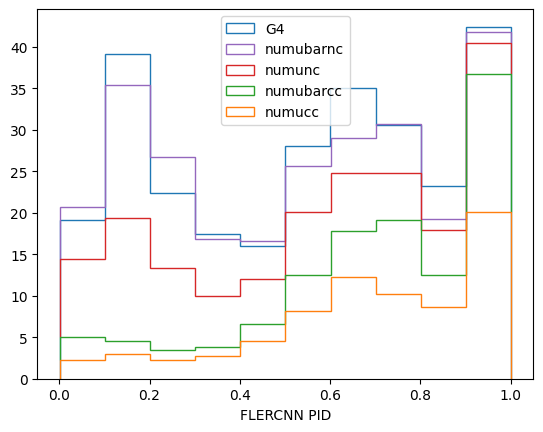

In [23]:
plt.hist(geant4['numu'][FLERCNN_vars['PID']][:],weights=geant4['numu'][FLERCNN_vars['weighted_aeff']][:],histtype='step',label='G4');

nus = (neu_1122['numu_cc'][FLERCNN_vars['PID']][:],
      neu_1122['numubar_cc'][FLERCNN_vars['PID']][:],
      neu_1122['numu_nc'][FLERCNN_vars['PID']][:],
      neu_1122['numubar_nc'][FLERCNN_vars['PID']][:])

ws = (neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:])

ls = ('numucc','numubarcc','numunc','numubarnc')

plt.hist(nus,weights=ws,histtype='step',stacked=True,label=ls);
plt.legend()
plt.xlabel('FLERCNN PID')

In [24]:
from neutrino_weighter_new_PISA import GENIENeutrinoWeighter_Backup

In [25]:
test_E = np.geomspace(1,1e4,200)
test_coszen = np.linspace(-1,1,50)

Es = []
coszs = []

for c in test_coszen:
    for E in test_E:
        Es.append(E)
        coszs.append(c)

Es = np.array(Es)
coszs = np.array(coszs)

In [26]:
fluxweights = GENIENeutrinoWeighter_Backup()

flav = [0,1,2]
nutype = [0,1] #0 nu, 1 nubar

nue_osc_flux_factor = fluxweights(Es,coszs,0,1,np.ones_like(Es))
nuebar_osc_flux_factor = fluxweights(Es,coszs,0,0,np.ones_like(Es))
numu_osc_flux_factor = fluxweights(Es,coszs,1,1,np.ones_like(Es))
numubar_osc_flux_factor = fluxweights(Es,coszs,1,0,np.ones_like(Es))
nutau_osc_flux_factor = fluxweights(Es,coszs,2,1,np.ones_like(Es))
nutaubar_osc_flux_factor = fluxweights(Es,coszs,2,0,np.ones_like(Es))

Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...
Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...
Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...
Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...
Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...
Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...


In [27]:
(np.median(nue_osc_flux_factor/nuebar_osc_flux_factor),
np.median(numu_osc_flux_factor/numubar_osc_flux_factor),
np.median(nutau_osc_flux_factor/nutaubar_osc_flux_factor))

(1.297322941306312, 1.4259916902936842, 1.4205208912371305)

In [28]:
(np.median(nue_osc_flux_factor),
np.median(numu_osc_flux_factor),
np.median(nutau_osc_flux_factor))

(2.9114655405027545e-05, 0.0003185840663483528, 8.255190470675413e-08)

In [29]:
(np.median(numu_osc_flux_factor/nue_osc_flux_factor),
 np.median(nue_osc_flux_factor/numu_osc_flux_factor),
 np.median(nutau_osc_flux_factor/nue_osc_flux_factor),
 np.median(nue_osc_flux_factor/nutau_osc_flux_factor), 
 np.median(nutau_osc_flux_factor/numu_osc_flux_factor),
 np.median(numu_osc_flux_factor/nutau_osc_flux_factor))

(11.246430591536495,
 0.08891710060663946,
 0.00209394968122852,
 477.5663984812506,
 0.0002618388264948153,
 3819.1542391562343)

In [30]:
import scipy.interpolate as sci

In [31]:
interp_E_pts = np.log(test_E)
interp_cosz_pts = test_coszen
interp_values = nue_osc_flux_factor.reshape(200,50)

nue_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              nue_osc_flux_factor.reshape(200,50))
nuebar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     nuebar_osc_flux_factor.reshape(200,50))
numu_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              numu_osc_flux_factor.reshape(200,50))
numubar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     numubar_osc_flux_factor.reshape(200,50))
nutau_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              nutau_osc_flux_factor.reshape(200,50))
nutaubar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     nutaubar_osc_flux_factor.reshape(200,50))

In [32]:
nue_cc_pts = np.array((np.log(nue_cc_true_energy),nue_cc_true_coszen)).T
nuebar_cc_pts = np.array((np.log(nuebar_cc_true_energy),nuebar_cc_true_coszen)).T
nue_nc_pts = np.array((np.log(nue_nc_true_energy),nue_nc_true_coszen)).T
nuebar_nc_pts = np.array((np.log(nuebar_nc_true_energy),nuebar_nc_true_coszen)).T

numu_cc_pts = np.array((np.log(numu_cc_true_energy),numu_cc_true_coszen)).T
numubar_cc_pts = np.array((np.log(numubar_cc_true_energy),numubar_cc_true_coszen)).T
numu_nc_pts = np.array((np.log(numu_nc_true_energy),numu_nc_true_coszen)).T
numubar_nc_pts = np.array((np.log(numubar_nc_true_energy),numubar_nc_true_coszen)).T

nutau_cc_pts = np.array((np.log(nutau_cc_true_energy),nutau_cc_true_coszen)).T
nutaubar_cc_pts = np.array((np.log(nutaubar_cc_true_energy),nutaubar_cc_true_coszen)).T
nutau_nc_pts = np.array((np.log(nutau_nc_true_energy),nutau_nc_true_coszen)).T
nutaubar_nc_pts = np.array((np.log(nutaubar_nc_true_energy),nutaubar_nc_true_coszen)).T

In [33]:
np.median(numu_flux_interp(numu_cc_pts)),np.median(numu_osc_flux_factor)

(0.03744789841185848, 0.0003185840663483528)

In [34]:
nue_cc_flux_osc_weights = nue_cc_weights * nue_flux_interp(nue_cc_pts)
nuebar_cc_flux_osc_weights = nuebar_cc_weights * nuebar_flux_interp(nuebar_cc_pts)
nue_nc_flux_osc_weights = nue_nc_weights * nue_flux_interp(nue_nc_pts)
nuebar_nc_flux_osc_weights = nuebar_nc_weights * nuebar_flux_interp(nuebar_nc_pts)

numu_cc_flux_osc_weights = numu_cc_weights * numu_flux_interp(numu_cc_pts)
numubar_cc_flux_osc_weights = numubar_cc_weights * numubar_flux_interp(numubar_cc_pts)
numu_nc_flux_osc_weights = numu_nc_weights * numu_flux_interp(numu_nc_pts)
numubar_nc_flux_osc_weights = numubar_nc_weights * numubar_flux_interp(numubar_nc_pts)

nutau_cc_flux_osc_weights = nutau_cc_weights * nutau_flux_interp(nutau_cc_pts)
nutaubar_cc_flux_osc_weights = nutaubar_cc_weights * nutaubar_flux_interp(nutaubar_cc_pts)
nutau_nc_flux_osc_weights = nutau_nc_weights * nutau_flux_interp(nutau_nc_pts)
nutaubar_nc_flux_osc_weights = nutaubar_nc_weights * nutaubar_flux_interp(nutaubar_nc_pts)

In [35]:
binning = np.linspace(0,1,21)

signal = (numu_cc_PID, numubar_cc_PID)
signal_weights = (numu_cc_flux_osc_weights, numubar_cc_flux_osc_weights)
signal_labels = ('numu_cc','numubar_cc')
signal_color = ('blue','darkblue')

numu_bkg = (numu_nc_PID, numubar_nc_PID)
numu_bkg_weights = (numu_nc_flux_osc_weights, numubar_nc_flux_osc_weights)
numu_bkg_labels = ('numu_nc','numubar_nc')
numu_bkg_color = ('green','darkgreen')

other_bkg = (nue_cc_PID, nuebar_cc_PID, nue_nc_PID, nuebar_nc_PID, nutau_cc_PID, nutaubar_cc_PID, nutau_nc_PID, nutaubar_nc_PID)
other_bkg_weights = (nue_cc_flux_osc_weights, nuebar_cc_flux_osc_weights, nue_nc_flux_osc_weights, nuebar_nc_flux_osc_weights,
                    nutau_cc_flux_osc_weights, nutaubar_cc_flux_osc_weights, nutau_nc_flux_osc_weights, nutaubar_nc_flux_osc_weights)
other_bkg_labels = ('nue_cc','nuebar_cc','nue_nc','nuebar_nc','nutau_cc','nutaubar_cc','nutau_nc','nutaubar_nc')
other_bkg_color = ('orange','darkorange','red','darkred','violet','darkviolet','magenta','darkmagenta')

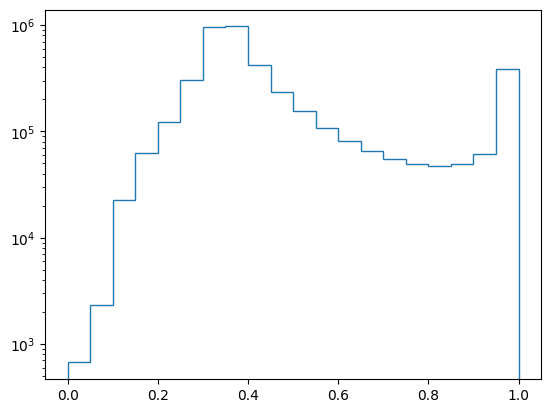

In [36]:
numus=(np.append(numu_cc_PID,numubar_cc_PID))
numus_weights=(np.append(numu_cc_flux_osc_weights,numubar_cc_flux_osc_weights))

plt.hist(numus,histtype='step',bins=binning)
plt.yscale('log')

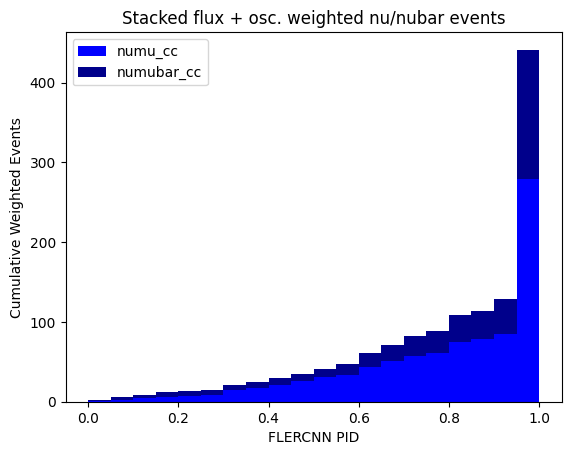

In [37]:
plot_PID = signal
plot_weights = signal_weights
plot_labels = signal_labels
plot_colors = signal_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

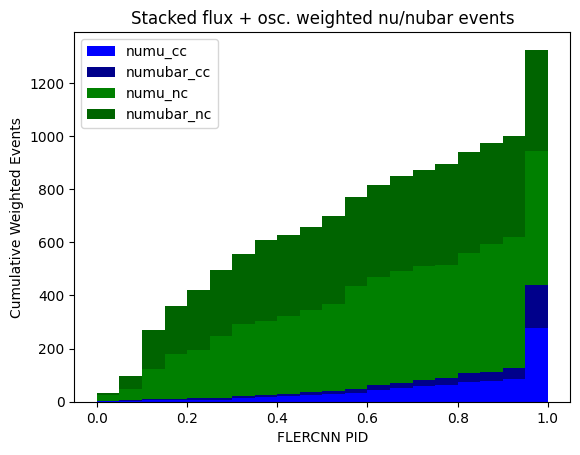

In [38]:
plot_PID = signal + numu_bkg
plot_weights = signal_weights + numu_bkg_weights
plot_labels = signal_labels + numu_bkg_labels
plot_colors = signal_color + numu_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

In [39]:
len(numu_cc_PID),len(numubar_cc_PID),len(numu_nc_PID),len(numubar_nc_PID),(len(numu_cc_PID)+
                                                                           len(numubar_cc_PID)+
                                                                           len(numu_nc_PID)+
                                                                           len(numubar_nc_PID))

(2827758, 1333946, 322554, 103555, 4587813)

In [40]:
(np.median(numu_cc_flux_osc_weights),np.median(numubar_cc_flux_osc_weights),
 np.median(numu_nc_flux_osc_weights),np.median(numubar_nc_flux_osc_weights))

(2.661893730514123e-10,
 1.9358979220095535e-10,
 3.928443590475177e-09,
 9.966254781064378e-09)

In [41]:
(np.median(numu_cc_flux_osc_weights)/np.median(numu_nc_flux_osc_weights),np.median(numubar_cc_flux_osc_weights)/
 np.median(numubar_nc_flux_osc_weights))

(0.0677594998937517, 0.019424527714139002)

In [42]:
np.median(numu_cc_weights),np.median(numubar_cc_weights),np.median(numu_nc_weights),np.median(numubar_nc_weights)

(6.476049165381977e-09,
 5.3401466191485535e-09,
 1.005842150022681e-07,
 2.606926331584961e-07)

In [43]:
(len(numu_cc_PID)*np.median(numu_cc_flux_osc_weights),
 len(numubar_cc_PID)*np.median(numubar_cc_flux_osc_weights),
 len(numu_nc_PID)*np.median(numu_nc_flux_osc_weights),
 len(numubar_nc_PID)*np.median(numubar_nc_flux_osc_weights))

(0.0007527191291611155,
 0.00025823832894729555,
 0.0012671351938821301,
 0.0010320555138531218)

In [44]:
(np.median(numu_flux_interp(numu_cc_pts)),
 np.median(numubar_flux_interp(numubar_cc_pts)),
 np.median(numu_flux_interp(numu_nc_pts)),
 np.median(numubar_flux_interp(numubar_nc_pts)))

(0.03744789841185848,
 0.031309748138034894,
 0.05054248041338712,
 0.05115283770409083)

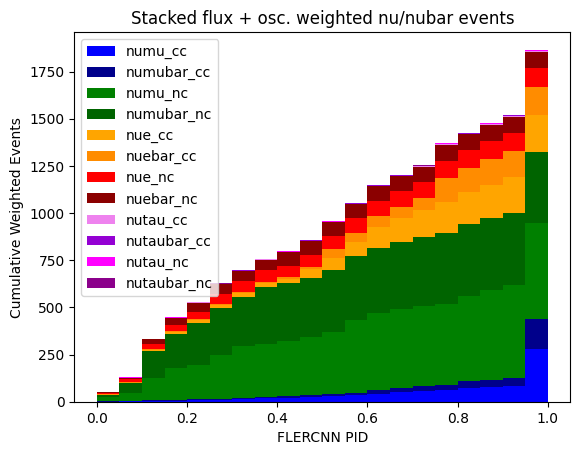

In [45]:
plot_PID = signal + numu_bkg + other_bkg
plot_weights = signal_weights + numu_bkg_weights + other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

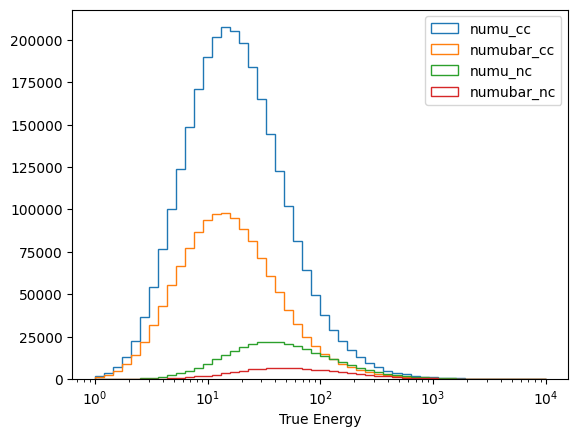

In [46]:
plt.hist(numu_cc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numu_cc')
plt.hist(numubar_cc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numubar_cc')
plt.hist(numu_nc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numu_nc')
plt.hist(numubar_nc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numubar_nc')

plt.xscale('log')
plt.xlabel('True Energy')
plt.legend()

In [47]:
binning = np.linspace(0,1,21)

signal_acuts = (numu_cc_PID[numu_cc_analysis_cuts], numubar_cc_PID[numubar_cc_analysis_cuts])
signal_weights_acuts = (numu_cc_flux_osc_weights[numu_cc_analysis_cuts], numubar_cc_flux_osc_weights[numubar_cc_analysis_cuts])

numu_bkg_acuts = (numu_nc_PID[numu_nc_analysis_cuts], numubar_nc_PID[numubar_nc_analysis_cuts])
numu_bkg_weights_acuts = (numu_nc_flux_osc_weights[numu_nc_analysis_cuts], numubar_nc_flux_osc_weights[numubar_nc_analysis_cuts])

other_bkg_acuts = (nue_cc_PID[nue_cc_analysis_cuts], nuebar_cc_PID[nuebar_cc_analysis_cuts], 
                   nue_nc_PID[nue_nc_analysis_cuts], nuebar_nc_PID[nuebar_nc_analysis_cuts], 
                   nutau_cc_PID[nutau_cc_analysis_cuts], nutaubar_cc_PID[nutaubar_cc_analysis_cuts], 
                   nutau_nc_PID[nutau_nc_analysis_cuts], nutaubar_nc_PID[nutaubar_nc_analysis_cuts])

other_bkg_weights_acuts = (nue_cc_flux_osc_weights[nue_cc_analysis_cuts], nuebar_cc_flux_osc_weights[nuebar_cc_analysis_cuts], 
                           nue_nc_flux_osc_weights[nue_nc_analysis_cuts], nuebar_nc_flux_osc_weights[nuebar_nc_analysis_cuts],
                           nutau_cc_flux_osc_weights[nutau_cc_analysis_cuts], nutaubar_cc_flux_osc_weights[nutaubar_cc_analysis_cuts], 
                           nutau_nc_flux_osc_weights[nutau_nc_analysis_cuts], nutaubar_nc_flux_osc_weights[nutaubar_nc_analysis_cuts])

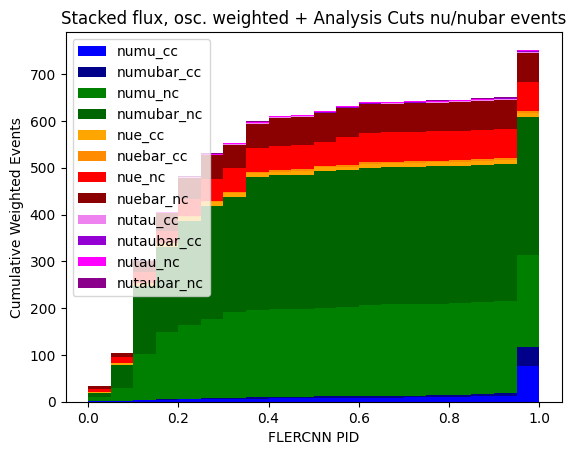

In [48]:
plot_PID = signal_acuts + numu_bkg_acuts + other_bkg_acuts
plot_weights = signal_weights_acuts + numu_bkg_weights_acuts + other_bkg_weights_acuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux, osc. weighted + Analysis Cuts nu/nubar events')
plt.legend(loc=2)

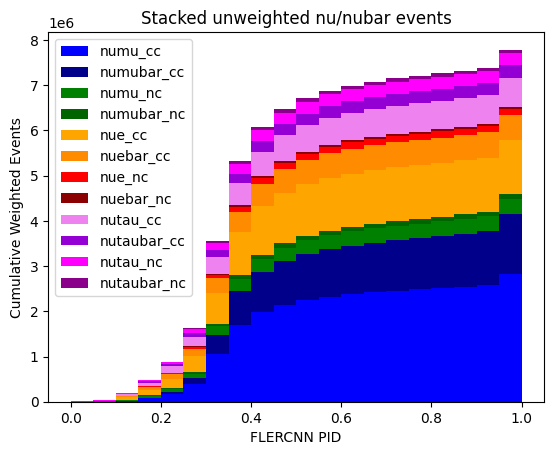

In [49]:
plot_PID = signal + numu_bkg + other_bkg
plot_weights = signal_weights + numu_bkg_weights + other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked unweighted nu/nubar events')
plt.legend(loc=2)

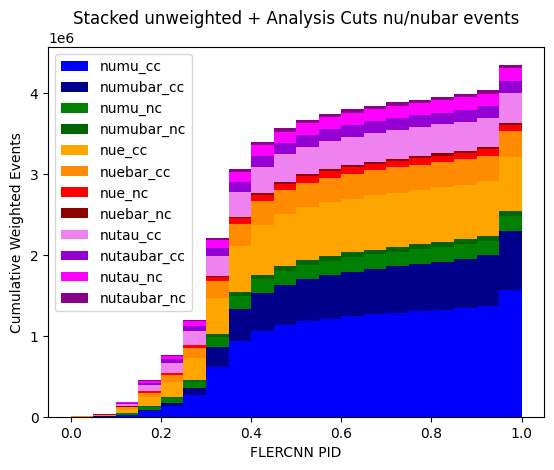

In [50]:
plot_PID = signal_acuts + numu_bkg_acuts + other_bkg_acuts
plot_weights = signal_weights_acuts + numu_bkg_weights_acuts + other_bkg_weights_acuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked unweighted + Analysis Cuts nu/nubar events')
plt.legend(loc=2)

In [51]:
binning = np.linspace(0,1,21)

nue_cc_cut = nue_cc_analysis_cuts & nue_cc_minE_cuts
nuebar_cc_cut = nuebar_cc_analysis_cuts & nuebar_cc_minE_cuts
nue_nc_cut = nue_nc_analysis_cuts & nue_nc_minE_cuts
nuebar_nc_cut = nuebar_nc_analysis_cuts & nuebar_nc_minE_cuts

numu_cc_cut = numu_cc_analysis_cuts & numu_cc_minE_cuts
numubar_cc_cut = numubar_cc_analysis_cuts & numubar_cc_minE_cuts
numu_nc_cut = numu_nc_analysis_cuts & numu_nc_minE_cuts
numubar_nc_cut = numubar_nc_analysis_cuts & numubar_nc_minE_cuts

nutau_cc_cut = nutau_cc_analysis_cuts & nutau_cc_minE_cuts
nutaubar_cc_cut = nutaubar_cc_analysis_cuts & nutaubar_cc_minE_cuts
nutau_nc_cut = nutau_nc_analysis_cuts & nutau_nc_minE_cuts
nutaubar_nc_cut = nutaubar_nc_analysis_cuts & nutaubar_nc_minE_cuts

signal_aecuts = (numu_cc_PID[numu_cc_cut], numubar_cc_PID[numubar_cc_cut])
signal_weights_aecuts = (numu_cc_flux_osc_weights[numu_cc_cut], numubar_cc_flux_osc_weights[numubar_cc_cut])

numu_bkg_aecuts = (numu_nc_PID[numu_nc_cut], numubar_nc_PID[numubar_nc_cut])
numu_bkg_weights_aecuts = (numu_nc_flux_osc_weights[numu_nc_cut], numubar_nc_flux_osc_weights[numubar_nc_cut])

other_bkg_aecuts = (nue_cc_PID[nue_cc_cut], nuebar_cc_PID[nuebar_cc_cut], 
                   nue_nc_PID[nue_nc_cut], nuebar_nc_PID[nuebar_nc_cut], 
                   nutau_cc_PID[nutau_cc_cut], nutaubar_cc_PID[nutaubar_cc_cut], 
                   nutau_nc_PID[nutau_nc_cut], nutaubar_nc_PID[nutaubar_nc_cut])

other_bkg_weights_aecuts = (nue_cc_flux_osc_weights[nue_cc_cut], nuebar_cc_flux_osc_weights[nuebar_cc_cut], 
                           nue_nc_flux_osc_weights[nue_nc_cut], nuebar_nc_flux_osc_weights[nuebar_nc_cut],
                           nutau_cc_flux_osc_weights[nutau_cc_cut], nutaubar_cc_flux_osc_weights[nutaubar_cc_cut], 
                           nutau_nc_flux_osc_weights[nutau_nc_cut], nutaubar_nc_flux_osc_weights[nutaubar_nc_cut])

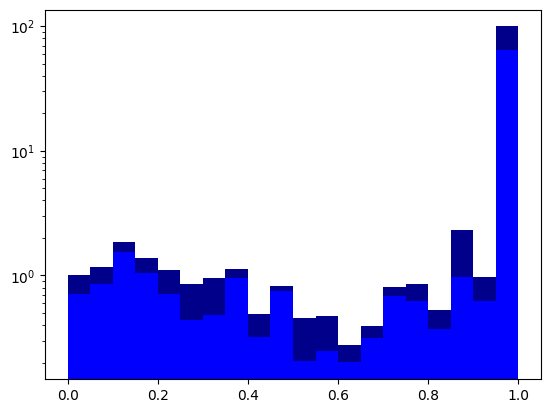

In [52]:
plt.hist(signal_acuts,histtype='bar',weights=signal_weights_acuts,
         color=signal_color,stacked=True,bins=np.linspace(0,1,21),label=plot_labels)
plt.yscale('log')

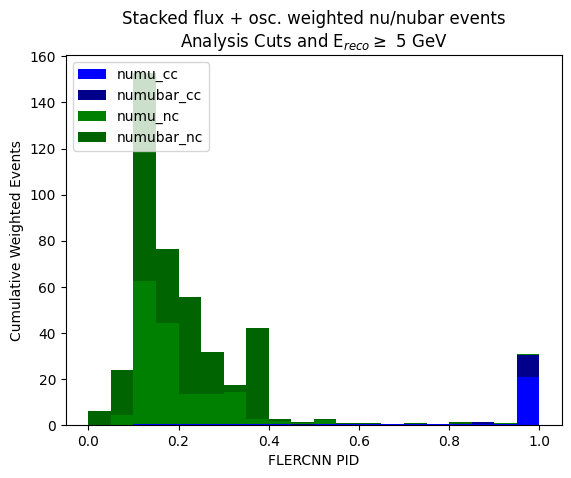

In [53]:
plot_PID = signal_aecuts + numu_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels
plot_colors = signal_color + numu_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and E$_{reco} \geq $ 5 GeV')
plt.legend(loc=2)

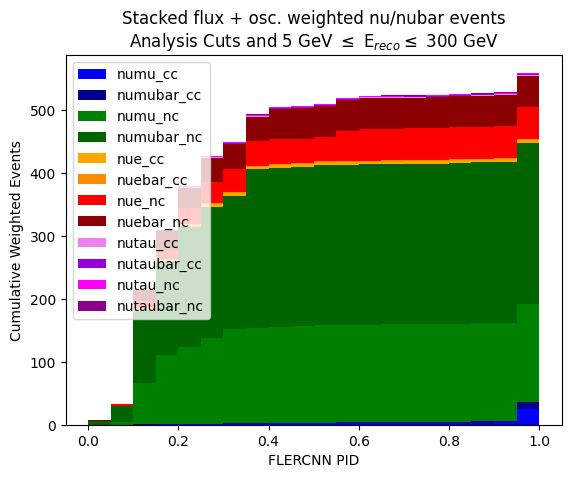

In [54]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $ E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [55]:
for w in plot_weights:
    print(np.mean(w))

1.790820294099137e-05
1.9149205208619092e-05
0.0009596790711677931
0.004883007508418966
7.300415293683803e-06
6.377858301466338e-06
0.0007134069943113856
0.0022113851953676853
4.678831576803986e-06
6.07561357085533e-06
1.0114009291365464e-05
2.4014284306837873e-05


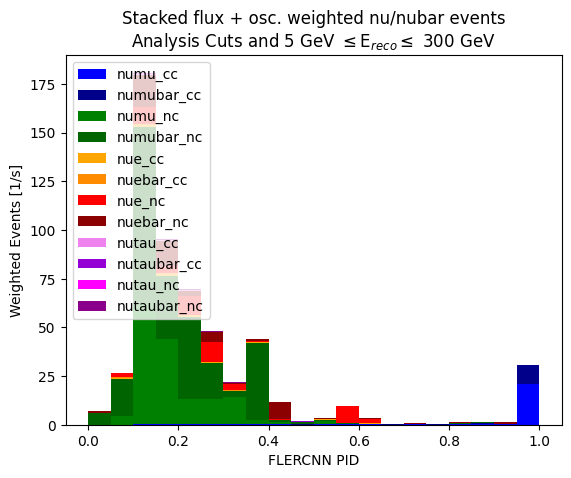

In [56]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Weighted Events [1/s]')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [57]:
totl=0
for i in plot_PID:
    totl+=len(i)
totl

3806898

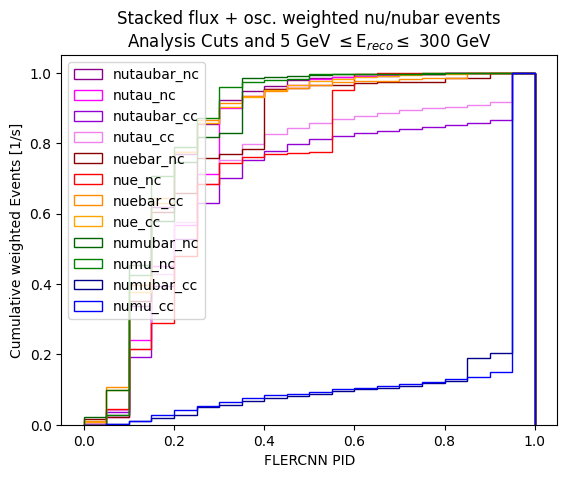

In [58]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts

plotweights_normed = list(np.zeros((12,)))
for i,weight in enumerate(plot_weights):
    plotweights_normed[i]=weight/np.sum(weight)
plotweights_normed=tuple(plotweights_normed)
    
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='step',weights=plotweights_normed,
         color=plot_colors,bins=binning,cumulative=True,stacked=False,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative weighted Events [1/s]')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [59]:
l=0
totl=0
for k in neu_1122.keys():
    l=len(neu_1122[k]['weighted_aeff'][:])
    totl+=l
    print(l,totl)

1196838 1196838
142004 1338842
556397 1895239
44948 1940187
2827758 4767945
322554 5090499
1333946 6424445
103555 6528000
642072 7170072
269763 7439835
267061 7706896
79074 7785970


### Proper Flux Weights

In [60]:
weight_file = hdf.File('FluxOscWeights/fluxoscweights.h5','r')

In [61]:
proper_flux_osc_weights_nue_cc = weight_file['nue_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nuebar_cc = weight_file['nuebar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nue_nc = weight_file['nue_nc_osc_flux_weights'][:]
proper_flux_osc_weights_nuebar_nc = weight_file['nuebar_nc_osc_flux_weights'][:]

proper_flux_osc_weights_numu_cc = weight_file['numu_cc_osc_flux_weights'][:]
proper_flux_osc_weights_numubar_cc = weight_file['numubar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_numu_nc = weight_file['numu_nc_osc_flux_weights'][:]
proper_flux_osc_weights_numubar_nc = weight_file['numubar_nc_osc_flux_weights'][:]

proper_flux_osc_weights_nutau_cc = weight_file['nutau_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nutaubar_cc = weight_file['nutaubar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nutau_nc = weight_file['nutau_nc_osc_flux_weights'][:]
proper_flux_osc_weights_nutaubar_nc = weight_file['nutaubar_nc_osc_flux_weights'][:]

In [62]:
proper_signal_weights = (proper_flux_osc_weights_numu_cc, proper_flux_osc_weights_numubar_cc)
proper_numu_bkg_weights = (proper_flux_osc_weights_numu_nc, proper_flux_osc_weights_numubar_nc)
proper_other_bkg_weights = (proper_flux_osc_weights_nue_cc, proper_flux_osc_weights_nuebar_cc, 
                     proper_flux_osc_weights_nue_nc, proper_flux_osc_weights_nuebar_nc,
                     proper_flux_osc_weights_nutau_cc, proper_flux_osc_weights_nutaubar_cc, 
                     proper_flux_osc_weights_nutau_nc, proper_flux_osc_weights_nutaubar_nc)

In [63]:
len(signal[1]),len(proper_signal_weights[1])

(1333946, 1333946)

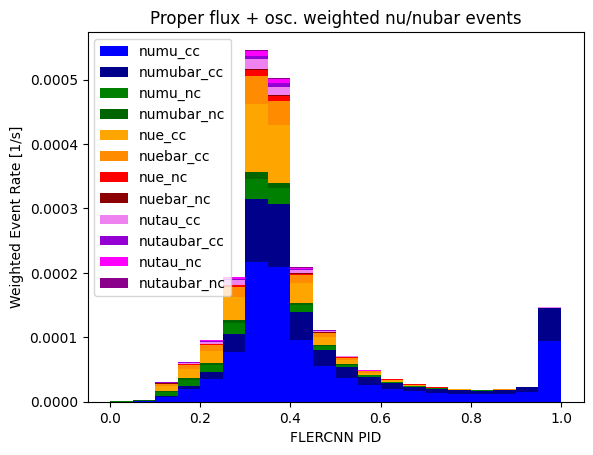

In [64]:
plot_PID = signal + numu_bkg + other_bkg
proper_plot_weights = proper_signal_weights + proper_numu_bkg_weights + proper_other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=proper_plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=False,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Weighted Event Rate [1/s]')
plt.title('Proper flux + osc. weighted nu/nubar events')
plt.legend(loc=2)

In [65]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=x, lw=2) for x in plot_colors]

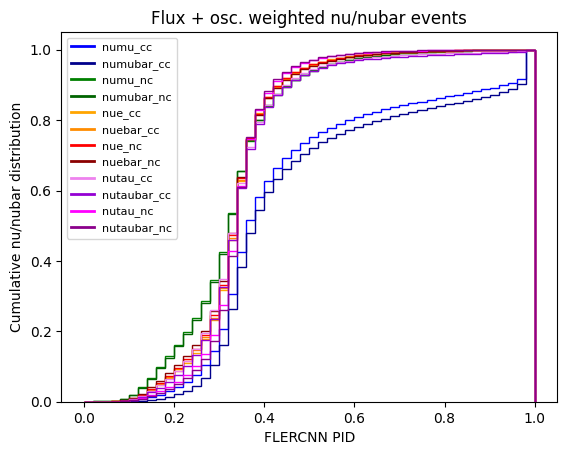

In [66]:
pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x/np.sum(x) for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]

for num in range(len(pid_array)):
    plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative nu/nubar distribution')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)

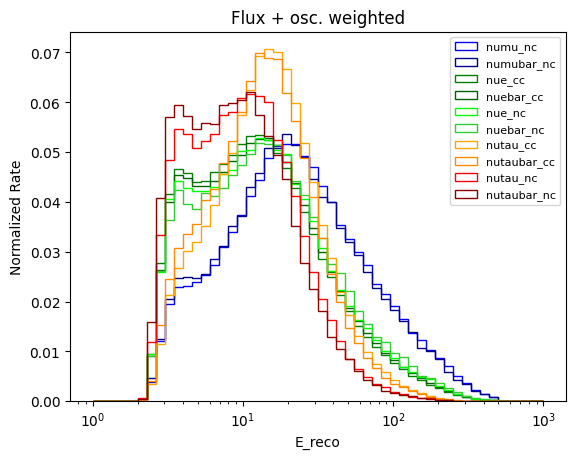

In [67]:
plt.hist(neu_1122['numu_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_numu_nc
         /np.sum(proper_flux_osc_weights_numu_nc),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_numubar_nc
         /np.sum(proper_flux_osc_weights_numubar_nc),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_1122['nue_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nue_cc
         /np.sum(proper_flux_osc_weights_nue_cc),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nuebar_cc
         /np.sum(proper_flux_osc_weights_nuebar_cc),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_1122['nue_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nue_nc
         /np.sum(proper_flux_osc_weights_nue_nc),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nuebar_nc
         /np.sum(proper_flux_osc_weights_nuebar_nc),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutau_cc
         /np.sum(proper_flux_osc_weights_nutau_cc),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutaubar_cc
         /np.sum(proper_flux_osc_weights_nutaubar_cc),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutau_nc
         /np.sum(proper_flux_osc_weights_nutau_nc),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutaubar_nc
         /np.sum(proper_flux_osc_weights_nutaubar_nc),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)

In [68]:
split_weight_file = hdf.File('FluxOscWeights/weights_splitfactors.h5','r')

In [69]:
numu_nc_prob = split_weight_file['numu_nc_probfactor'][:]
numu_nc_flux = split_weight_file['numu_nc_fluxfactor'][:]
numu_nc_aeff = split_weight_file['numu_nc_aefffactor'][:]

numubar_nc_prob = split_weight_file['numubar_nc_probfactor'][:]
numubar_nc_flux = split_weight_file['numubar_nc_fluxfactor'][:]
numubar_nc_aeff = split_weight_file['numubar_nc_aefffactor'][:]

nue_nc_prob = split_weight_file['nue_nc_probfactor'][:]
nue_nc_flux = split_weight_file['nue_nc_fluxfactor'][:]
nue_nc_aeff = split_weight_file['nue_nc_aefffactor'][:]

nuebar_nc_prob = split_weight_file['nuebar_nc_probfactor'][:]
nuebar_nc_flux = split_weight_file['nuebar_nc_fluxfactor'][:]
nuebar_nc_aeff = split_weight_file['nuebar_nc_aefffactor'][:]

nue_cc_prob = split_weight_file['nue_cc_probfactor'][:]
nue_cc_flux = split_weight_file['nue_cc_fluxfactor'][:]
nue_cc_aeff = split_weight_file['nue_cc_aefffactor'][:]

nuebar_cc_prob = split_weight_file['nuebar_cc_probfactor'][:]
nuebar_cc_flux = split_weight_file['nuebar_cc_fluxfactor'][:]
nuebar_cc_aeff = split_weight_file['nuebar_cc_aefffactor'][:]

nutau_nc_prob = split_weight_file['nutau_nc_probfactor'][:]
nutau_nc_flux = split_weight_file['nutau_nc_fluxfactor'][:]
nutau_nc_aeff = split_weight_file['nutau_nc_aefffactor'][:]

nutaubar_nc_prob = split_weight_file['nutaubar_nc_probfactor'][:]
nutaubar_nc_flux = split_weight_file['nutaubar_nc_fluxfactor'][:]
nutaubar_nc_aeff = split_weight_file['nutaubar_nc_aefffactor'][:]

nutau_cc_prob = split_weight_file['nutau_cc_probfactor'][:]
nutau_cc_flux = split_weight_file['nutau_cc_fluxfactor'][:]
nutau_cc_aeff = split_weight_file['nutau_cc_aefffactor'][:]

nutaubar_cc_prob = split_weight_file['nutaubar_cc_probfactor'][:]
nutaubar_cc_flux = split_weight_file['nutaubar_cc_fluxfactor'][:]
nutaubar_cc_aeff = split_weight_file['nutaubar_cc_aefffactor'][:]

In [70]:
numu_nc_w = numu_nc_aeff[1]
numu_nc_wf = numu_nc_aeff[1] * numu_nc_flux[1]
numu_nc_wfp = np.sum(numu_nc_aeff[1] * numu_nc_prob * numu_nc_flux,axis=0)

numubar_nc_w = numubar_nc_aeff[1]
numubar_nc_wf = numubar_nc_aeff[1] * numubar_nc_flux[1]
numubar_nc_wfp = np.sum(numubar_nc_aeff[1] * numubar_nc_prob * numubar_nc_flux,axis=0)

nue_cc_w = nue_cc_aeff[1]
nue_cc_wf = nue_cc_aeff[1] * nue_cc_flux[0]
nue_cc_wfp = np.sum(nue_cc_aeff[1] * nue_cc_prob * nue_cc_flux,axis=0)

nuebar_cc_w = nuebar_cc_aeff[1]
nuebar_cc_wf = nuebar_cc_aeff[1] * nuebar_cc_flux[0]
nuebar_cc_wfp = np.sum(nuebar_cc_aeff[1] * nuebar_cc_prob * nuebar_cc_flux,axis=0)

nue_nc_w = nue_nc_aeff[1]
nue_nc_wf = nue_nc_aeff[1] * nue_nc_flux[0]
nue_nc_wfp = np.sum(nue_nc_aeff[1] * nue_nc_prob * nue_nc_flux,axis=0)

nuebar_nc_w = nuebar_nc_aeff[1]
nuebar_nc_wf = nuebar_nc_aeff[1] * nuebar_nc_flux[0]
nuebar_nc_wfp = np.sum(nuebar_nc_aeff[1] * nuebar_nc_prob * nuebar_nc_flux,axis=0)

nutau_cc_w = nutau_cc_aeff[1]
nutau_cc_wf = np.zeros_like(nutau_cc_aeff[1] * nutau_cc_flux[0])
nutau_cc_wfp = np.sum(nutau_cc_aeff[1] * nutau_cc_prob * nutau_cc_flux,axis=0)

nutaubar_cc_w = nutaubar_cc_aeff[1]
nutaubar_cc_wf = np.zeros_like(nutaubar_cc_aeff[1] * nutaubar_cc_flux[0])
nutaubar_cc_wfp = np.sum(nutaubar_cc_aeff[1] * nutaubar_cc_prob * nutaubar_cc_flux,axis=0)

nutau_nc_w = nutau_nc_aeff[1]
nutau_nc_wf = np.zeros_like(nutau_nc_aeff[1] * nutau_nc_flux[0])
nutau_nc_wfp = np.sum(nutau_nc_aeff[1] * nutau_nc_prob * nutau_nc_flux,axis=0)

nutaubar_nc_w = nutaubar_nc_aeff[1]
nutaubar_nc_wf = np.zeros_like(nutaubar_nc_aeff[1] * nutaubar_nc_flux[0])
nutaubar_nc_wfp = np.sum(nutaubar_nc_aeff[1] * nutaubar_nc_prob * nutaubar_nc_flux,axis=0)

In [71]:
neu_0000 = hdf.File(folder+pisahdf_filenames['0000'],'r')

[ WARNING] /tmp/ipykernel_3514464/3566780245.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3566780245.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3566780245.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf

[ WARNING] /tmp/ipykernel_3514464/3566780245.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf



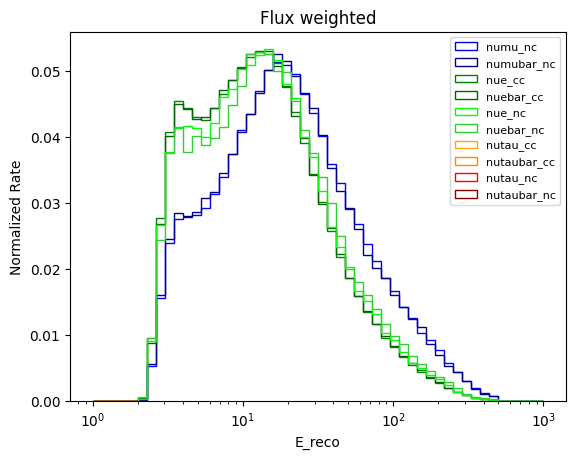

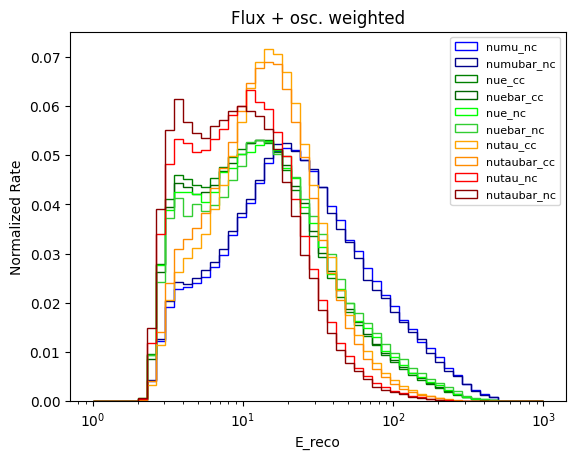

In [72]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wf
         /np.sum(numu_nc_wf),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wf
         /np.sum(numubar_nc_wf),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wf
         /np.sum(nue_cc_wf),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wf
         /np.sum(nuebar_cc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wf
         /np.sum(nue_nc_wf),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wf
         /np.sum(nuebar_nc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf
         /np.sum(nutau_cc_wf),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf
         /np.sum(nutau_nc_wf),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux weighted')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wfp
         /np.sum(numu_nc_wfp),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wfp
         /np.sum(numubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wfp
         /np.sum(nue_cc_wfp),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wfp
         /np.sum(nue_nc_wfp),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wfp
         /np.sum(nutau_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wfp
         /np.sum(nutau_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)
plt.show()

[ WARNING] /tmp/ipykernel_3514464/3914355883.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3914355883.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3914355883.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf

[ WARNING] /tmp/ipykernel_3514464/3914355883.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf



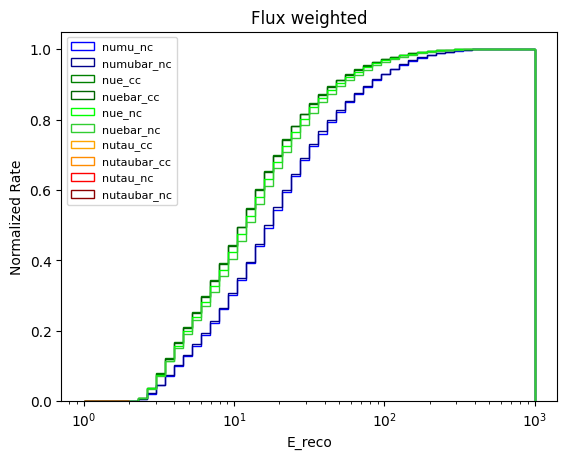

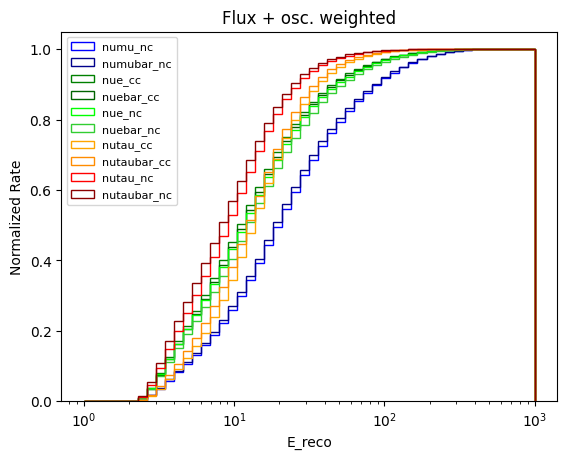

In [73]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wf
         /np.sum(numu_nc_wf),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wf
         /np.sum(numubar_nc_wf),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wf
         /np.sum(nue_cc_wf),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wf
         /np.sum(nuebar_cc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wf
         /np.sum(nue_nc_wf),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wf
         /np.sum(nuebar_nc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf
         /np.sum(nutau_cc_wf),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf
         /np.sum(nutau_nc_wf),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux weighted')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wfp
         /np.sum(numu_nc_wfp),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wfp
         /np.sum(numubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wfp
         /np.sum(nue_cc_wfp),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wfp
         /np.sum(nue_nc_wfp),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wfp
         /np.sum(nutau_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wfp
         /np.sum(nutau_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)
plt.show()

In [74]:
numu_nc_0000_lowpid = neu_0000['numu_nc'][FLERCNN_vars['PID']][:] < 0.35
numubar_nc_0000_lowpid = neu_0000['numubar_nc'][FLERCNN_vars['PID']][:] < 0.35
nue_cc_0000_lowpid = neu_0000['nue_cc'][FLERCNN_vars['PID']][:] < 0.35
nuebar_cc_0000_lowpid = neu_0000['nuebar_cc'][FLERCNN_vars['PID']][:] < 0.35
nue_nc_0000_lowpid = neu_0000['nue_nc'][FLERCNN_vars['PID']][:] < 0.35
nuebar_nc_0000_lowpid = neu_0000['nuebar_nc'][FLERCNN_vars['PID']][:] < 0.35
nutau_cc_0000_lowpid = neu_0000['nutau_cc'][FLERCNN_vars['PID']][:] < 0.35
nutaubar_cc_0000_lowpid = neu_0000['nutaubar_cc'][FLERCNN_vars['PID']][:] < 0.35
nutau_nc_0000_lowpid = neu_0000['nutau_nc'][FLERCNN_vars['PID']][:] < 0.35
nutaubar_nc_0000_lowpid = neu_0000['nutaubar_nc'][FLERCNN_vars['PID']][:] < 0.35

[ WARNING] /tmp/ipykernel_3514464/2609583152.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf

[ WARNING] /tmp/ipykernel_3514464/2609583152.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf

[ WARNING] /tmp/ipykernel_3514464/2609583152.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf

[ WARNING] /tmp/ipykernel_3514464/2609583152.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf



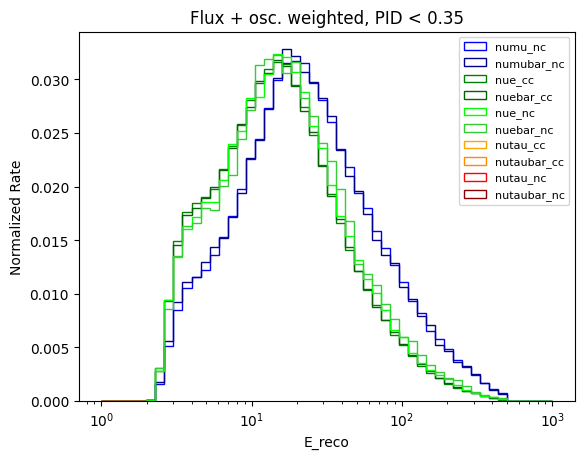

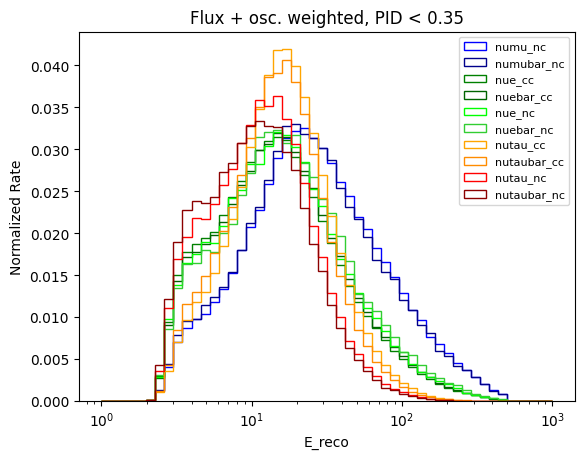

In [75]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wf
         /np.sum(numu_nc_wf))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wf
         /np.sum(numubar_nc_wf))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wf
         /np.sum(nue_cc_wf))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wf
         /np.sum(nuebar_cc_wf))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wf
         /np.sum(nue_nc_wf))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wf
         /np.sum(nuebar_nc_wf))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf
         /np.sum(nutau_cc_wf))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf
         /np.sum(nutau_nc_wf))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wfp
         /np.sum(numu_nc_wfp))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wfp
         /np.sum(numubar_nc_wfp))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wfp
         /np.sum(nue_cc_wfp))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wfp
         /np.sum(nue_nc_wfp))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wfp
         /np.sum(nutau_cc_wfp))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wfp
         /np.sum(nutau_nc_wfp))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

[ WARNING] /tmp/ipykernel_3514464/3781187619.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3781187619.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf

[ WARNING] /tmp/ipykernel_3514464/3781187619.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf

[ WARNING] /tmp/ipykernel_3514464/3781187619.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf



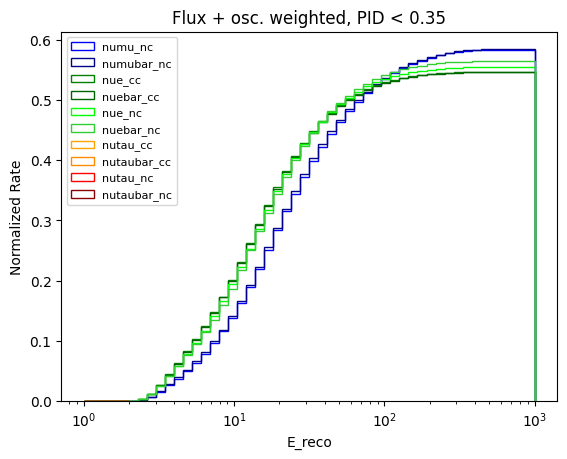

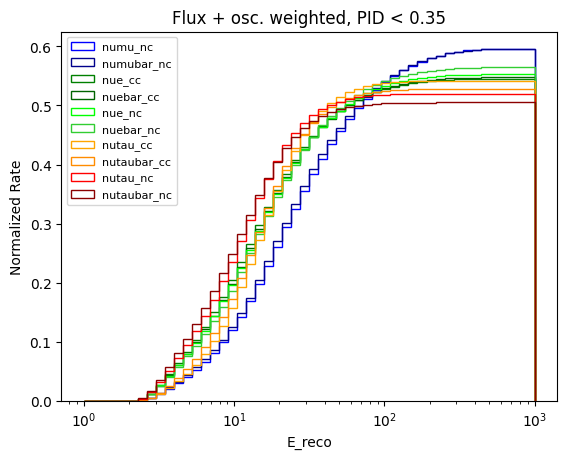

In [76]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wf
         /np.sum(numu_nc_wf))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wf
         /np.sum(numubar_nc_wf))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wf
         /np.sum(nue_cc_wf))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wf
         /np.sum(nuebar_cc_wf))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wf
         /np.sum(nue_nc_wf))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wf
         /np.sum(nuebar_nc_wf))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf
         /np.sum(nutau_cc_wf))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf
         /np.sum(nutau_nc_wf))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wfp
         /np.sum(numu_nc_wfp))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wfp
         /np.sum(numubar_nc_wfp))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wfp
         /np.sum(nue_cc_wfp))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wfp
         /np.sum(nue_nc_wfp))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wfp
         /np.sum(nutau_cc_wfp))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wfp
         /np.sum(nutau_nc_wfp))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

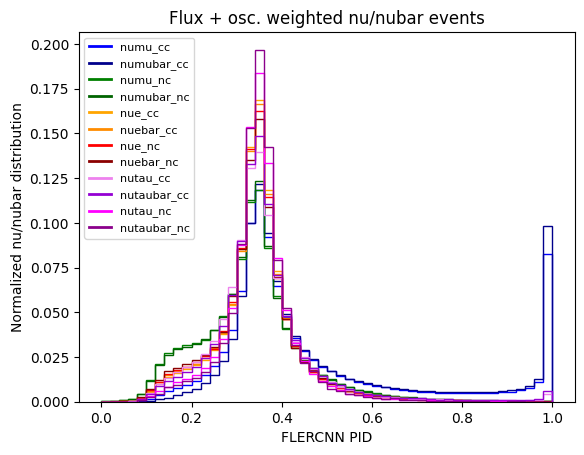

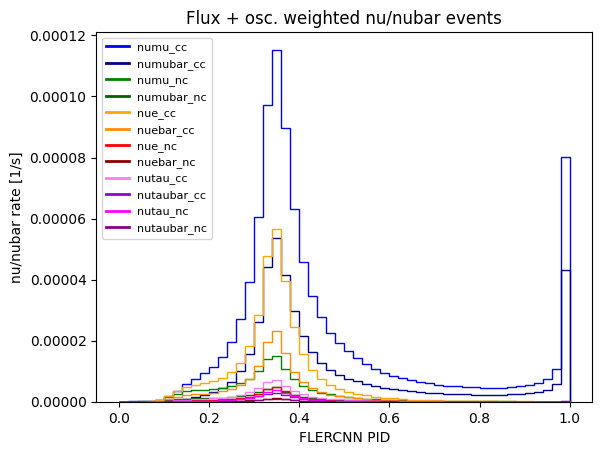

In [77]:
pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x/np.sum(x) for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]

for num in range(len(pid_array)):
    plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=False,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('Normalized nu/nubar distribution')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)
plt.show()

pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]
hist_vals = [np.zeros_like(np.linspace(0,1,51)) for x in plot_PID]

for num in range(len(pid_array)):
    hist_vals[num],_,_=plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=False,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('nu/nubar rate [1/s]')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)
plt.show()

In [78]:
numu_ccs_vals = hist_vals[0]+hist_vals[1]
numu_ncs_vals = hist_vals[2]+hist_vals[3]
other_vals = (hist_vals[4]+hist_vals[5]+
             hist_vals[6]+hist_vals[7]+
             hist_vals[8]+hist_vals[9]+
             hist_vals[10]+hist_vals[11])
total_vals = numu_ccs_vals + numu_ncs_vals + other_vals

rightside_numu_ccs_purity = np.zeros_like(numu_ccs_vals)
rightside_numus_purity = np.zeros_like(numu_ccs_vals)
rightside_other_purity = np.zeros_like(numu_ccs_vals)

for i in range(len(rightside_numu_ccs_purity)):
    rightside_numu_ccs_purity[i] = np.sum(numu_ccs_vals[i:])/np.sum(total_vals[i:])
    rightside_numus_purity[i] = np.sum(numu_ccs_vals[i:]+numu_ncs_vals[i:])/np.sum(total_vals[i:])
    rightside_other_purity[i] = np.sum(other_vals[i:])/np.sum(total_vals[i:])

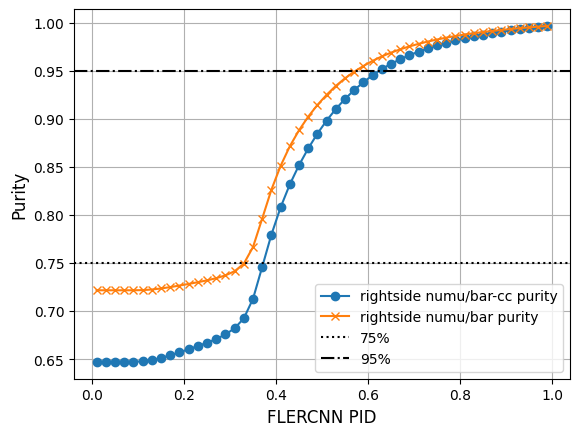

In [79]:
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numu_ccs_purity,label='rightside numu/bar-cc purity',marker='o')
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numus_purity,label='rightside numu/bar purity',marker='x')
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_other_purity,label='rightside nues/nutaus purity',marker='x')
plt.xlabel('FLERCNN PID',fontsize=12)
plt.ylabel('Purity',fontsize=12)
#plt.axhline(y=.10,label='10%',color='black',ls='dashed')
plt.axhline(y=.75,label='75%',color='black',ls='dotted')
plt.axhline(y=.95,label='95%',color='black',ls='dashdot')
plt.grid()
plt.legend()

In [80]:
cutoff = np.sum(rightside_numu_ccs_purity < 0.95)

rightside_numu_ccs_purity_mixed = np.zeros(cutoff)
rightside_numus_purity_mixed = np.zeros(cutoff)
rightside_other_purity_mixed = np.zeros(cutoff)

for i in range(cutoff):
    rightside_numu_ccs_purity_mixed[i] = np.sum(numu_ccs_vals[i:cutoff])/np.sum(total_vals[i:cutoff])
    rightside_numus_purity_mixed[i] = np.sum(numu_ccs_vals[i:cutoff]+numu_ncs_vals[i:cutoff])/np.sum(total_vals[i:cutoff])
    rightside_other_purity_mixed[i] = np.sum(other_vals[i:cutoff])/np.sum(total_vals[i:cutoff])

In [81]:
rightside_numu_ccs_purity_mixed > 0.70

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [82]:
mixedcutoff = np.argmax(rightside_numu_ccs_purity_mixed > 0.70)
cutoff_val = np.linspace(0,1,51)[mixedcutoff]
cutoff_val

0.4

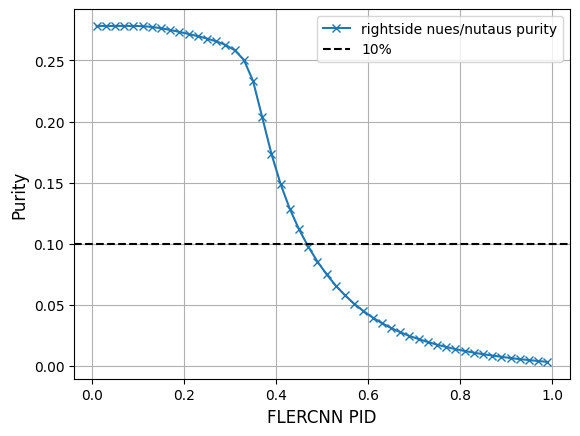

In [83]:
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numu_ccs_purity,label='rightside numu/bar-cc purity',marker='o')
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numus_purity,label='rightside numu/bar purity',marker='x')
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_other_purity,label='rightside nues/nutaus purity',marker='x')
plt.xlabel('FLERCNN PID',fontsize=12)
plt.ylabel('Purity',fontsize=12)
plt.axhline(y=.10,label='10%',color='black',ls='dashed')
#plt.axhline(y=.75,label='75%',color='black',ls='dotted')
#plt.axhline(y=.95,label='95%',color='black',ls='dashdot')
plt.grid()
plt.legend()

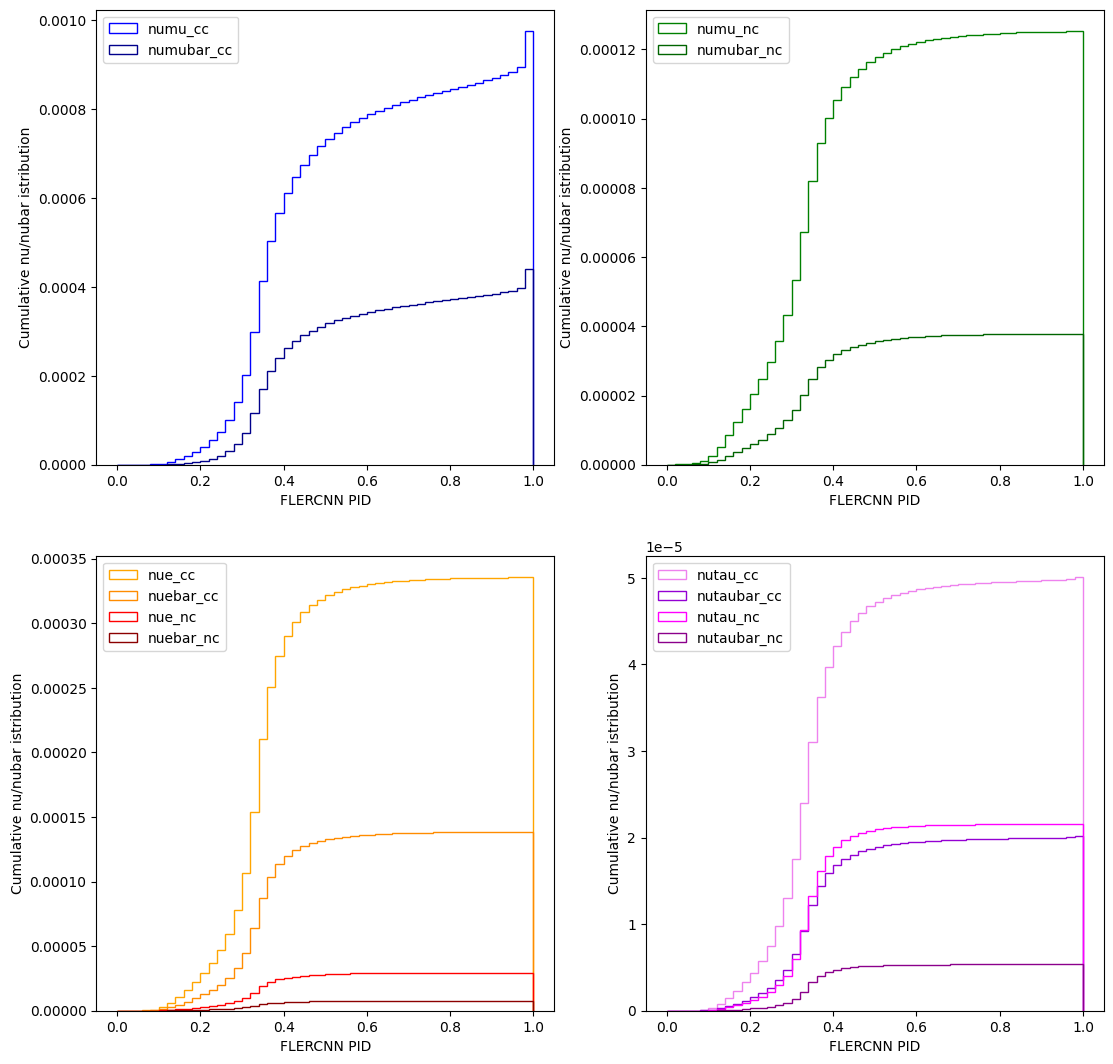

In [84]:
fig,axes = plt.subplots(nrows=2,ncols=2)
fig.set_figheight(13)
fig.set_figwidth(13)

for num in range(len(pid_array))[0:2]:
    axes[0,0].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[0,0].legend()
    axes[0,0].set_xlabel('FLERCNN PID')
    axes[0,0].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[2:4]:
    axes[0,1].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[0,1].legend()
    axes[0,1].set_xlabel('FLERCNN PID')
    axes[0,1].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[4:8]:
    axes[1,0].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[1,0].legend()
    axes[1,0].set_xlabel('FLERCNN PID')
    axes[1,0].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[8:12]:
    axes[1,1].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[1,1].legend()
    axes[1,1].set_xlabel('FLERCNN PID')
    axes[1,1].set_ylabel('Cumulative nu/nubar istribution')

In [85]:
mixed_purity = 0.75
high_purity = 0.95

In [86]:
label_array

['numu_cc',
 'numubar_cc',
 'numu_nc',
 'numubar_nc',
 'nue_cc',
 'nuebar_cc',
 'nue_nc',
 'nuebar_nc',
 'nutau_cc',
 'nutaubar_cc',
 'nutau_nc',
 'nutaubar_nc']

In [87]:
pid_weight_array = [x for x in proper_plot_weights]

pidrange = np.linspace(0,1,51)

numus_num = np.zeros_like(pidrange[:-1])
numus_cc_num = np.zeros_like(pidrange[:-1])
others_num = np.zeros_like(pidrange[:-1])

for p in range(len(pidrange)-1):
    for pa,pw,l in zip(pid_array,pid_weight_array,label_array):
        if 'numu' in l and 'cc' in l:
            numus_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])
        elif 'numu' in l and 'nc' in l:
            numus_cc_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])
        else:
            others_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])

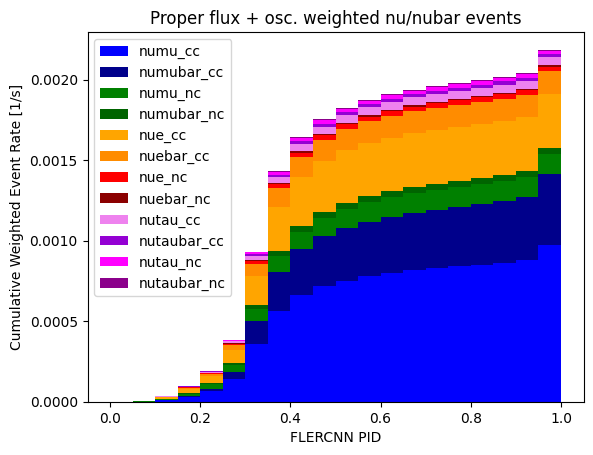

In [88]:
plot_PID = signal + numu_bkg + other_bkg
proper_plot_weights = proper_signal_weights + proper_numu_bkg_weights + proper_other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=proper_plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Event Rate [1/s]')
plt.title('Proper flux + osc. weighted nu/nubar events')
plt.legend(loc=2)

In [89]:
joinedsignal = []
for i in signal:
    joinedsignal+=list(i)

joinednumubkg = []
for i in numu_bkg:
    joinednumubkg+=list(i)

joinedotherbkg = []
for i in other_bkg:
    joinedotherbkg+=list(i)

joinedsignal_weights = []
for i in proper_signal_weights:
    joinedsignal_weights+=list(i)

joinednumubkg_weights = []
for i in proper_numu_bkg_weights:
    joinednumubkg_weights+=list(i)

joinedotherbkg_weights = []
for i in proper_other_bkg_weights:
    joinedotherbkg_weights+=list(i)

In [90]:
def weighted_quantile(
    values,
    quantiles,
    sample_weight=None,
    values_sorted=False,
):
    """
    Very close to numpy.percentile, but supports weights. Qantiles should be in [0, 1]!
    
    Parameters
    ----------
    values : array of floats
        Input data.
    quantiles : array of floats
        Quantile values to compute.
    sample_weight : array of floats
        Weights of the input data.
    values_sorted : bool
        Are the input values sorted, or not.

    Returns
    -------
    quantiles : array of floats
        Computed quantiles.
    """

    import numpy as np

    values = np.array(values)
    quantiles = np.array(quantiles)

    if values.size == 0: return(np.nan)

    if sample_weight is None:
        sample_weight = np.ones(len(values))

    sample_weight = np.array(sample_weight)

    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'   

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)

    return np.interp(quantiles, weighted_quantiles, values)

In [91]:
qs = [0.75,0.9,0.95,0.99]
qs_ls = [(0,(1,10)),'dotted',(0,(5,10)),'dashed']

qs_signal = weighted_quantile(values=joinedsignal,quantiles=qs,sample_weight=joinedsignal_weights)
qs_numu_bkg = weighted_quantile(values=joinednumubkg,quantiles=qs,sample_weight=joinednumubkg_weights)
qs_other_bkg = weighted_quantile(values=joinedotherbkg,quantiles=qs,sample_weight=joinedotherbkg_weights)

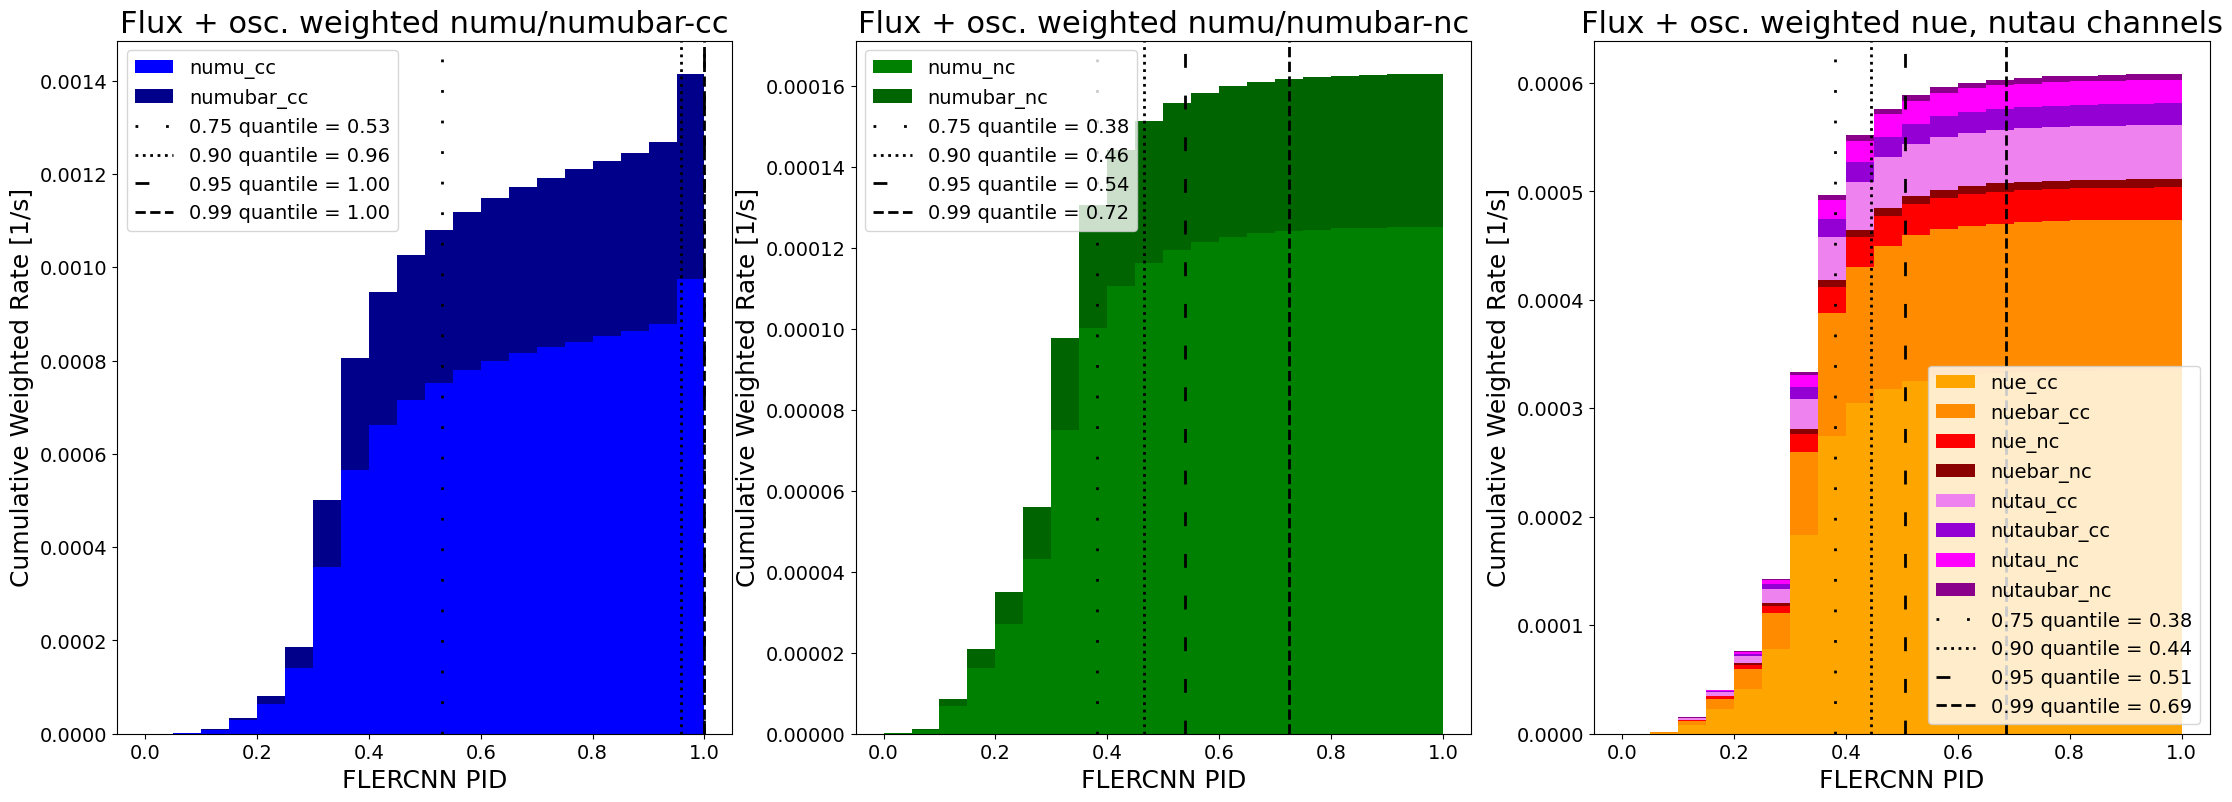

In [92]:
fig, axes = plt.subplots(ncols=3,nrows=1)
fig.set_figheight(9)
fig.set_figwidth(27)

axes[0].set_xlabel('FLERCNN PID',fontsize=18)
axes[0].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
s_ev,_,_=axes[0].hist(signal,histtype='bar',weights=proper_signal_weights,
         color=signal_color,bins=binning,stacked=True,cumulative=True,label=signal_labels)
axes[0].set_title('Flux + osc. weighted numu/numubar-cc',fontsize=22)
axes[0].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_signal):
    axes[0].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[0].legend(fontsize=14)

axes[1].set_xlabel('FLERCNN PID',fontsize=18)
axes[1].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
nbkg_ev,_,_=axes[1].hist(numu_bkg,histtype='bar',weights=proper_numu_bkg_weights,
         color=numu_bkg_color,bins=binning,stacked=True,cumulative=True,label=numu_bkg_labels)
axes[1].set_title('Flux + osc. weighted numu/numubar-nc',fontsize=22)
axes[1].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_numu_bkg):
    axes[1].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[1].legend(fontsize=14)
                
axes[2].set_xlabel('FLERCNN PID',fontsize=18)
axes[2].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
obkg_ev,_,_=axes[2].hist(other_bkg,histtype='bar',weights=proper_other_bkg_weights,
         color=other_bkg_color,bins=binning,stacked=True,cumulative=True,label=other_bkg_labels)
axes[2].set_title('Flux + osc. weighted nue, nutau channels',fontsize=22)
axes[2].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_other_bkg):
    axes[2].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[2].legend(fontsize=14)

In [93]:
#calculating cumulative from right

s_evs_c = s_ev[-1]

s_evs = np.ones(len(s_evs_c)-1)
s_evs[:] = s_evs_c[1:] - s_evs_c[:-1]
s_evs = np.append(s_evs_c[0],s_evs)

s_evs_right_c = np.zeros_like(s_evs_c)
for i in range(len(s_evs_right_c)):
    s_evs_right_c[i]=np.sum(s_evs[i:])

n_evs_c = nbkg_ev[-1]

n_evs = np.ones(len(n_evs_c)-1)
n_evs[:] = n_evs_c[1:] - n_evs_c[:-1]
n_evs = np.append(n_evs_c[0],n_evs)

n_evs_right_c = np.zeros_like(n_evs_c)
for i in range(len(n_evs_right_c)):
    n_evs_right_c[i]=np.sum(n_evs[i:])

o_evs_c = obkg_ev[-1]

o_evs = np.ones(len(o_evs_c)-1)
o_evs[:] = o_evs_c[1:] - o_evs_c[:-1]
o_evs = np.append(o_evs_c[0],o_evs)

o_evs_right_c = np.zeros_like(o_evs_c)
for i in range(len(o_evs_right_c)):
    o_evs_right_c[i]=np.sum(o_evs[i:])

Text(0.5, 1.0, 'Flux+ Osc. Weighted rate fractions')

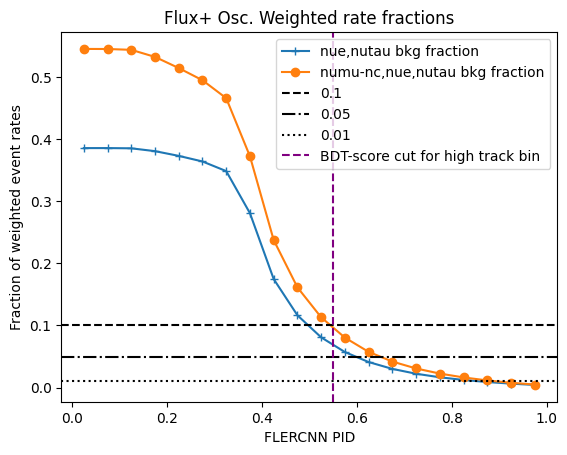

In [94]:
other_to_numu_fraction_right = o_evs_right_c/(s_evs_right_c+n_evs_right_c)
bkg_fraction = (o_evs_right_c+n_evs_right_c)/s_evs_right_c

plt.plot(np.linspace(0,1,21)[:-1]+0.025,other_to_numu_fraction_right,label='nue,nutau bkg fraction',marker='+')
plt.plot(np.linspace(0,1,21)[:-1]+0.025,bkg_fraction,label='numu-nc,nue,nutau bkg fraction',marker='o')
plt.axhline(y=0.1,ls='dashed',label='0.1',color='black')
plt.axhline(y=0.05,ls='dashdot',label='0.05',color='black')
plt.axhline(y=0.01,ls='dotted',label='0.01',color='black')
plt.axvline(x=0.55,ls='dashed',label='BDT-score cut for high track bin',color='purple')
plt.xlabel('FLERCNN PID')
plt.ylabel('Fraction of weighted event rates')
plt.legend()
plt.title('Flux+ Osc. Weighted rate fractions')

## BDT_y double check

In [95]:
PIDbins = [0.38,0.64,1.0]
mixed_numu_cc = (numu_cc_PID < PIDbins[1]) & (numu_cc_PID > PIDbins[0])
mixed_numubar_cc = (numubar_cc_PID < PIDbins[1]) & (numubar_cc_PID > PIDbins[0])
high_numu_cc = (numu_cc_PID < PIDbins[2]) & (numu_cc_PID > PIDbins[1])
high_numubar_cc = (numubar_cc_PID < PIDbins[2]) & (numubar_cc_PID > PIDbins[1])
other_numu_cc = np.invert(np.logical_or(mixed_numu_cc,high_numu_cc))
other_numubar_cc = np.invert(np.logical_or(mixed_numubar_cc,high_numubar_cc))

In [96]:
y_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][:]
y_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][:]

reco_E_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:]
reco_E_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:]

In [97]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

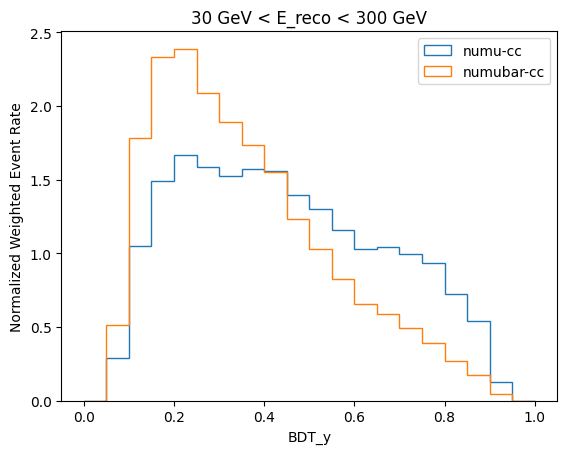

In [98]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

numu_cc_selection = numu_cc_reco_E_cut & numu_cc_analysis_cuts
numubar_cc_selection = numubar_cc_reco_E_cut & numubar_cc_analysis_cuts

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True,label='numu-cc',
        weights=proper_flux_osc_weights_numu_cc[numu_cc_selection])
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True,label='numubar-cc',
        weights=proper_flux_osc_weights_numubar_cc[numubar_cc_selection])
plt.xlabel('BDT_y')
plt.title('30 GeV < E_reco < 300 GeV')
plt.ylabel('Normalized Weighted Event Rate')
plt.legend()

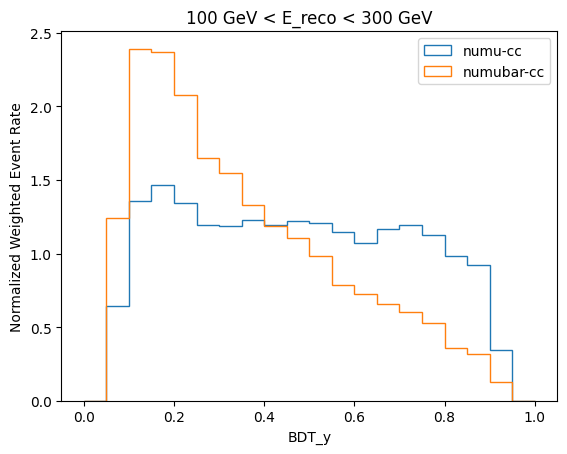

In [99]:
numu_cc_reco_E_cut = (100 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (100 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

numu_cc_selection = numu_cc_reco_E_cut & numu_cc_analysis_cuts
numubar_cc_selection = numubar_cc_reco_E_cut & numubar_cc_analysis_cuts

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True,label='numu-cc',
        weights=proper_flux_osc_weights_numu_cc[numu_cc_selection])
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True,label='numubar-cc',
        weights=proper_flux_osc_weights_numubar_cc[numubar_cc_selection])
plt.xlabel('BDT_y')
plt.title('100 GeV < E_reco < 300 GeV')
plt.ylabel('Normalized Weighted Event Rate')
plt.legend()

Text(0.5, 1.0, 'Reco_E < 30 GeV')

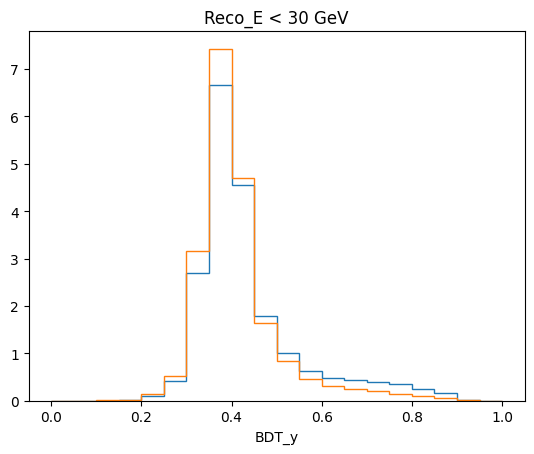

In [100]:
numu_cc_selection = np.invert(numu_cc_reco_E_cut) & numu_cc_analysis_cuts & other_numu_cc
numubar_cc_selection = np.invert(numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts & other_numubar_cc

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True)
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True)
plt.xlabel('BDT_y')
plt.title('Reco_E < 30 GeV')

Text(0.5, 1.0, 'Reco_E > 30 GeV')

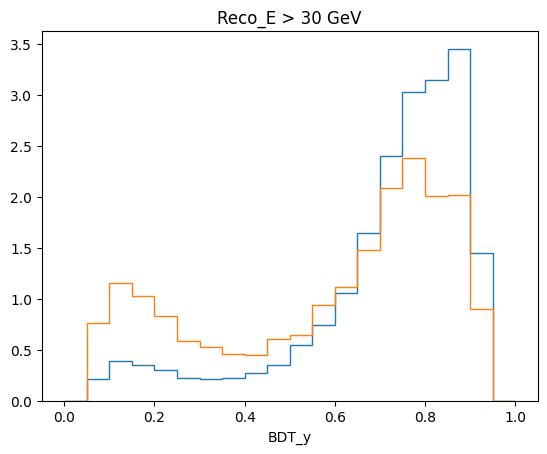

In [101]:
numu_cc_selection = (numu_cc_reco_E_cut) & numu_cc_analysis_cuts & other_numu_cc
numubar_cc_selection = (numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts & other_numubar_cc

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True)
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True)
plt.xlabel('BDT_y')
plt.title('Reco_E > 30 GeV')

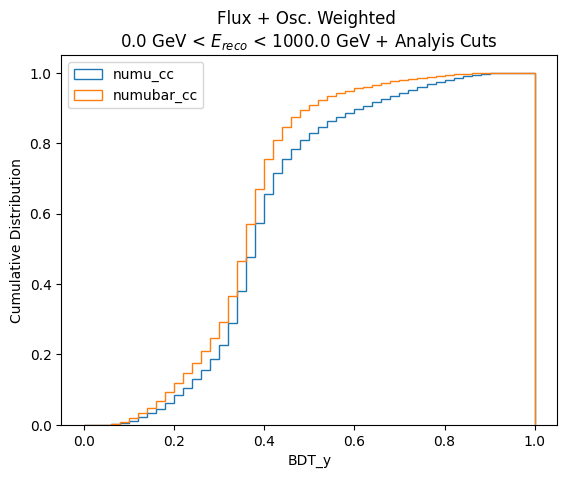

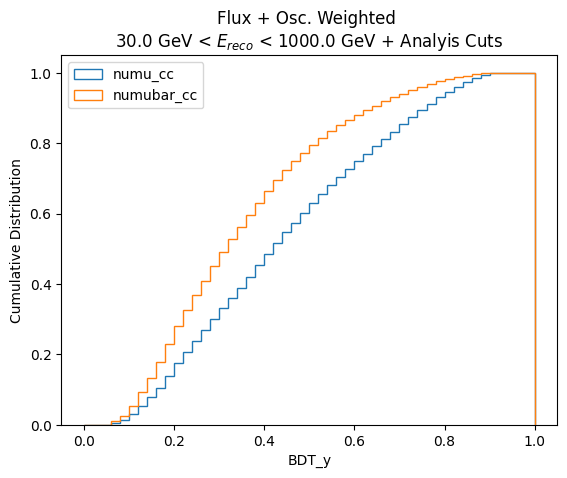

In [102]:
min_E_reco = 0
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts])))
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])))
plt.xlabel('BDT_y')
plt.ylabel('Cumulative Distribution')
plt.title('Flux + Osc. Weighted \n'+r'%0.1f GeV < $E_{reco}$ < %0.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco))
plt.legend()
plt.show()

dy=b-a


min_E_reco = 30
max_E_reco = 1000

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts])))
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])))
plt.xlabel('BDT_y')
plt.ylabel('Cumulative Distribution')
plt.title('Flux + Osc. Weighted \n'+r'%0.1f GeV < $E_{reco}$ < %0.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco))
plt.legend()
plt.show()

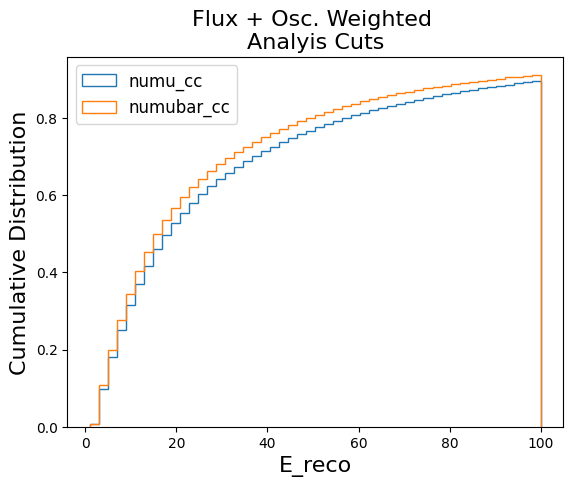

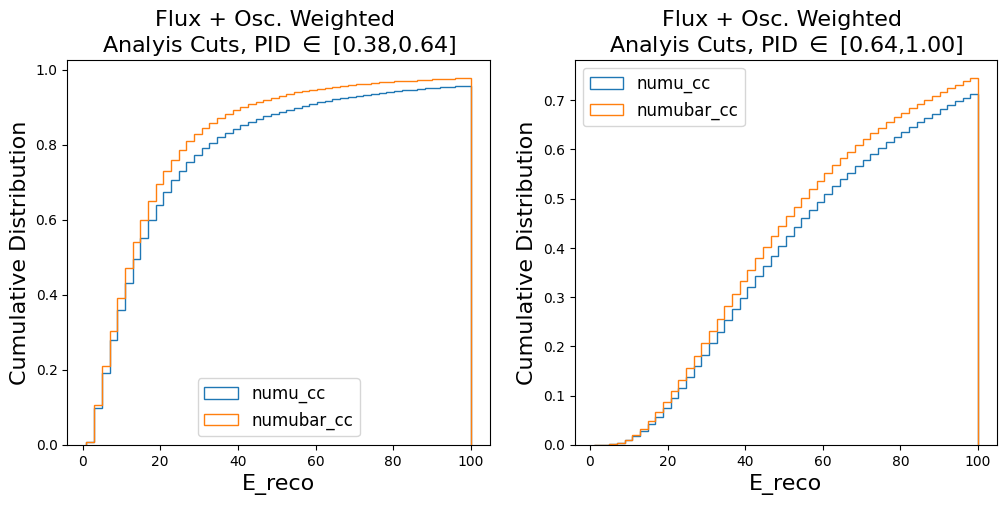

In [103]:
min_E_reco = 0
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=1,nrows=1)

a,_,_=axes.hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_analysis_cuts])))
b,_,_=axes.hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_analysis_cuts])))
axes.set_xlabel('E_reco',fontsize=16)
axes.set_ylabel('Cumulative Distribution',fontsize=16)
axes.set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts',fontsize=16)
axes.legend(fontsize=12)
plt.show()


fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][mixed_numu_cc & numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][mixed_numubar_cc & numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])))
axes[0].set_xlabel('E_reco',fontsize=16)
axes[0].set_ylabel('Cumulative Distribution',fontsize=16)
axes[0].set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts, PID $\in$ [0.38,0.64]',fontsize=16)
axes[0].legend(fontsize=12)

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][high_numu_cc & numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][high_numubar_cc & numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])))
axes[1].set_xlabel('E_reco',fontsize=16)
axes[1].set_ylabel('Cumulative Distribution',fontsize=16)
axes[1].set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts, PID $\in$ [0.64,1.00]',fontsize=16)
axes[1].legend(fontsize=12)

plt.show()

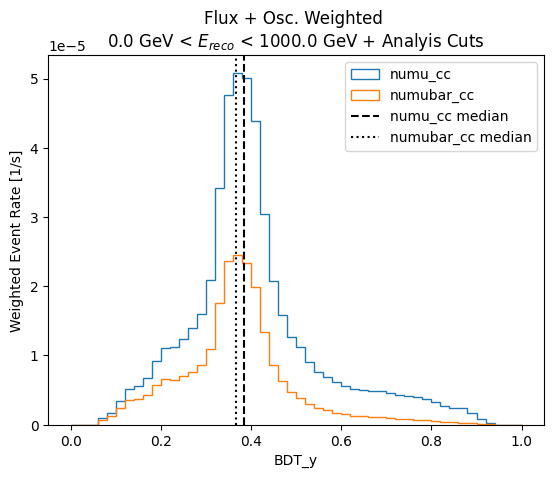

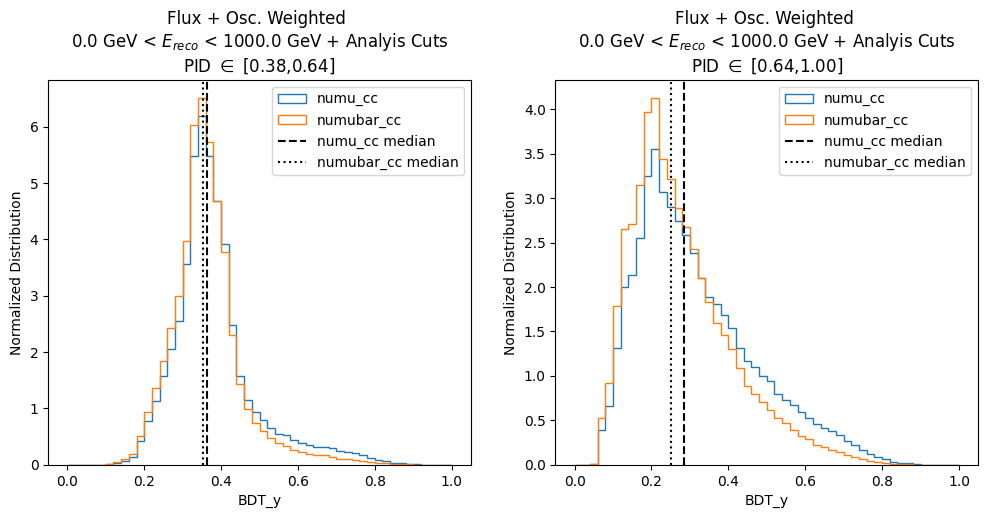

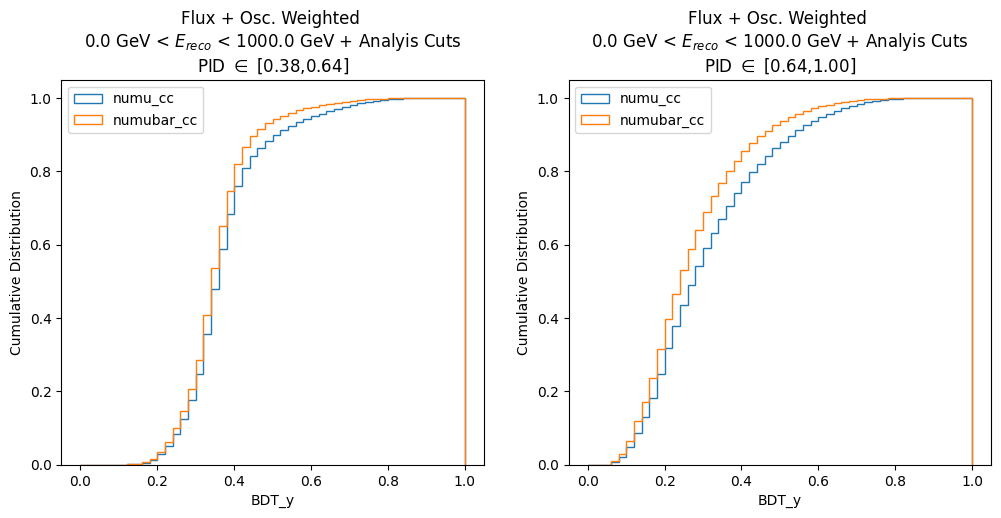

In [104]:
min_E_reco = 0e1
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=False,
         weights=proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=False,
         weights=proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
plt.axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
plt.axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
plt.xlabel('BDT_y')
plt.ylabel('Weighted Event Rate [1/s]')
plt.title('Flux + Osc. Weighted \n'+r'%0.1f GeV < $E_{reco}$ < %0.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco))
plt.legend()
plt.show()

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[0].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[0].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Normalized Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[1].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[1].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Normalized Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()

#cumulative

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_mixed = b-a
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Cumulative Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_high = b-a
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Cumulative Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()


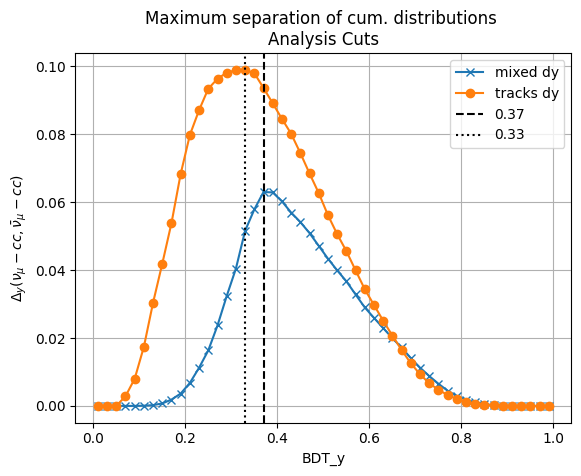

In [105]:
plt.plot(ybins[:-1]+0.01,dy_mixed,label='mixed dy',marker='x')
plt.plot(ybins[:-1]+0.01,dy_high,label='tracks dy',marker='o')
plt.ylabel(r'$\Delta_y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed)]+0.01,label='%0.2f' % (ybins[:-1][np.argmax(dy_mixed)]+0.01), color='black',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high)]+0.01,label='%0.2f' % (ybins[:-1][np.argmax(dy_high)]+0.01), color='black',ls='dotted')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [106]:
np.mean(neu_0000['numu_cc'][FLERCNN_vars['reco_energy']][:] < 10)

0.3175462193850158

In [107]:
E_min_mu = 10
E_mixed_mu = 30 
#prop length 100 GeV mu in ice: 1km, min DC 7 DOM separation: 7*7m
#also 99.99% exclusion margin around 10m/2GeV in DC energy region

In [108]:
min_E_reco = 0
max_E_reco = E_min_mu

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_mixed_lowE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
dy_high_lowE = b-a

plt.close()
plt.show()

min_E_reco = E_min_mu
max_E_reco = 1e3

numu_cc_reco_E_cut1 = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut1 = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]))
dy_mixed_highE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]));
dy_high_highE = b-a

plt.close()
plt.show()

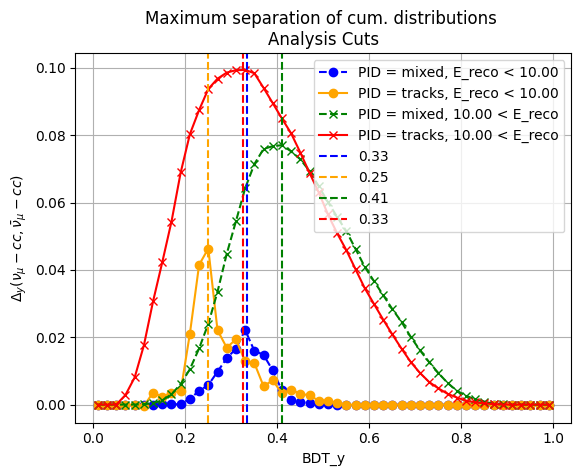

In [109]:
plt.plot(ybins[:-1]+0.01,dy_mixed_lowE,label='PID = mixed, E_reco < %0.2f' % E_min_mu,marker='o',ls='dashed',color='blue')
plt.plot(ybins[:-1]+0.01,dy_high_lowE,label='PID = tracks, E_reco < %0.2f' % E_min_mu,marker='o',color='orange')
plt.plot(ybins[:-1]+0.01,dy_mixed_highE,label='PID = mixed, %0.2f < E_reco' % E_min_mu,marker='x',ls='dashed',color='green')
plt.plot(ybins[:-1]+0.01,dy_high_highE,label='PID = tracks, %0.2f < E_reco' % E_min_mu,marker='x',color='red')
plt.ylabel(r'$\Delta_y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01+0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01), color='blue',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_lowE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_lowE)]+0.01), color='orange',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_highE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_highE)]+0.01), color='green',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_highE)]+0.01-0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_highE)]+0.01), color='red',ls='dashed')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [110]:
time = 9.28 * 365 * 24 * 60 *60

fraction_mixed_nu_lowE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                 [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_lowE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts])
fraction_mixed_nu_highE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                  [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_highE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                     [mixed_numubar_cc & numubar_cc_analysis_cuts])
num_mixed_nus = np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])*time
num_mixed_nubars = np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])*time

fraction_tracks_nu_lowE = np.mean((high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                  [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_lowE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                     [high_numubar_cc & numubar_cc_analysis_cuts])
fraction_tracks_nu_highE = np.mean((high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                   [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_highE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                      [high_numubar_cc & numubar_cc_analysis_cuts])
num_tracks_nus = np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])*time
num_tracks_nubars = np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])*time

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay 

In [112]:
fraction_mixed_nu_lowE,fraction_mixed_nu_highE

(0.36269951177106813, 0.6373004882289318)

Text(0.5, 1.0, 'PID=Tracks, Analysis-Cuts\nN$_{\\nu_\\mu-cc}$=35925.9, N$_{\\bar{\\nu}_\\mu-cc}$ =18612.1')

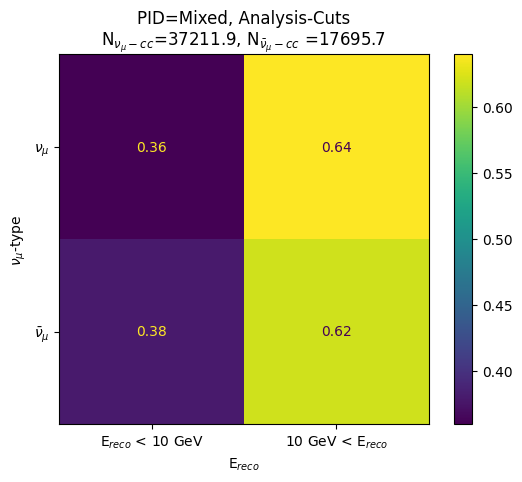

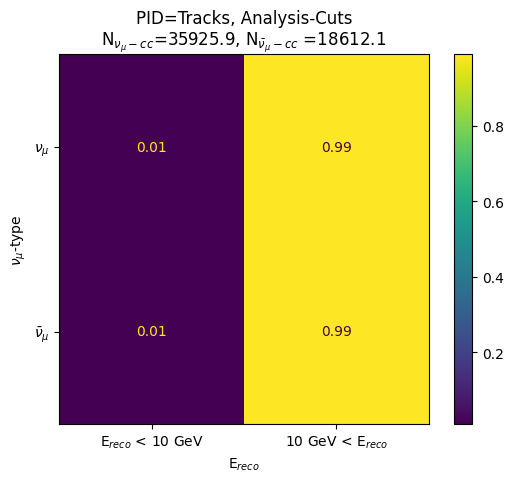

In [113]:
conf_mixed_fracs = np.array([[round(fraction_mixed_nu_lowE,2),round(fraction_mixed_nu_highE,2)],
                             [round(fraction_mixed_nubar_lowE,2),round(fraction_mixed_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'E$_{reco}$ < 10 GeV',r'10 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Mixed, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_mixed_nus,num_mixed_nubars))

conf_mixed_fracs = np.array([[round(fraction_tracks_nu_lowE,2),round(fraction_tracks_nu_highE,2)],
                             [round(fraction_tracks_nubar_lowE,2),round(fraction_tracks_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'E$_{reco}$ < 10 GeV',r'10 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Tracks, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_tracks_nus,num_tracks_nubars))

In [114]:
min_E_reco = E_min_mu
max_E_reco = E_mixed_mu

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_mixed_lowE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
dy_high_lowE = b-a

plt.close()
plt.show()

min_E_reco = E_mixed_mu
max_E_reco = 1e3

numu_cc_reco_E_cut1 = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut1 = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]))
dy_mixed_highE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts]));
dy_high_highE = b-a

plt.close()
plt.show()

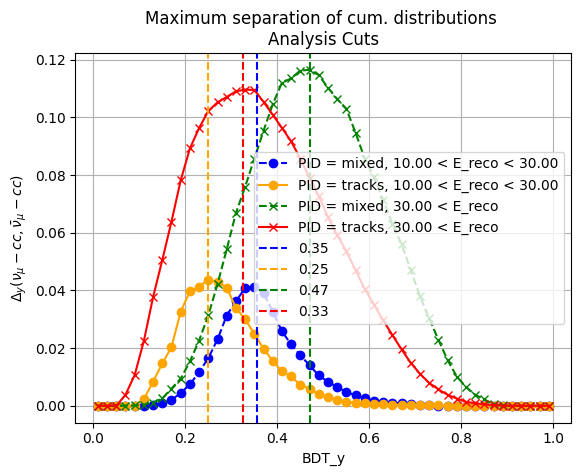

In [115]:
plt.plot(ybins[:-1]+0.01,dy_mixed_lowE,label='PID = mixed, 10.00 < E_reco < %0.2f' % E_mixed_mu,marker='o',ls='dashed',color='blue')
plt.plot(ybins[:-1]+0.01,dy_high_lowE,label='PID = tracks, 10.00 < E_reco < %0.2f' % E_mixed_mu,marker='o',color='orange')
plt.plot(ybins[:-1]+0.01,dy_mixed_highE,label='PID = mixed, %0.2f < E_reco' % E_mixed_mu,marker='x',ls='dashed',color='green')
plt.plot(ybins[:-1]+0.01,dy_high_highE,label='PID = tracks, %0.2f < E_reco' % E_mixed_mu,marker='x',color='red')
plt.ylabel(r'$\Delta_y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01+0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01), color='blue',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_lowE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_lowE)]+0.01), color='orange',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_highE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_highE)]+0.01), color='green',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_highE)]+0.01-0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_highE)]+0.01), color='red',ls='dashed')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [116]:
time = 9.28 * 365 * 24 * 60 *60

fraction_mixed_nu_lowE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                 [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_lowE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts])
fraction_mixed_nu_highE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                  [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_highE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                     [mixed_numubar_cc & numubar_cc_analysis_cuts])
num_mixed_nus = np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])*time
num_mixed_nubars = np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])*time

fraction_tracks_nu_lowE = np.mean((high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                  [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_lowE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                     [high_numubar_cc & numubar_cc_analysis_cuts])
fraction_tracks_nu_highE = np.mean((high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                   [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_highE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                      [high_numubar_cc & numubar_cc_analysis_cuts])
num_tracks_nus = np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])*time
num_tracks_nubars = np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])*time

Text(0.5, 1.0, 'PID=Tracks, Analysis-Cuts\nN$_{\\nu_\\mu-cc}$=35925.9, N$_{\\bar{\\nu}_\\mu-cc}$ =18612.1')

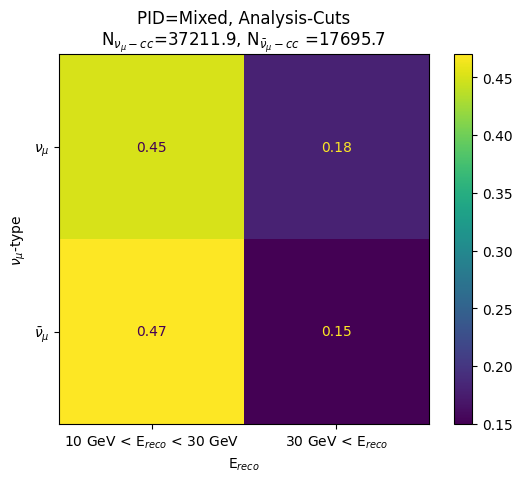

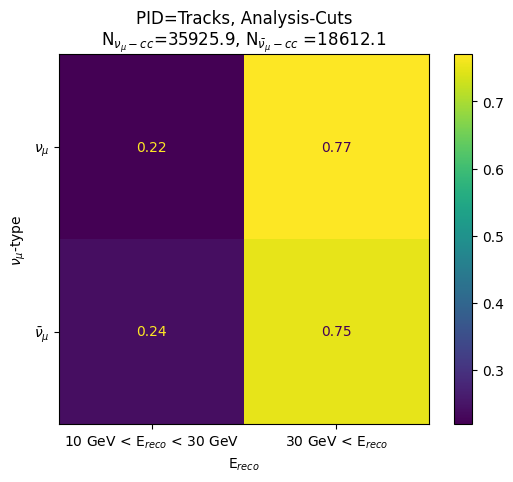

In [117]:
conf_mixed_fracs = np.array([[round(fraction_mixed_nu_lowE,2),round(fraction_mixed_nu_highE,2)],
                             [round(fraction_mixed_nubar_lowE,2),round(fraction_mixed_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'10 GeV < E$_{reco}$ < 30 GeV',r'30 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Mixed, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_mixed_nus,num_mixed_nubars))

conf_mixed_fracs = np.array([[round(fraction_tracks_nu_lowE,2),round(fraction_tracks_nu_highE,2)],
                             [round(fraction_tracks_nubar_lowE,2),round(fraction_tracks_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'10 GeV < E$_{reco}$ < 30 GeV',r'30 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Tracks, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_tracks_nus,num_tracks_nubars))

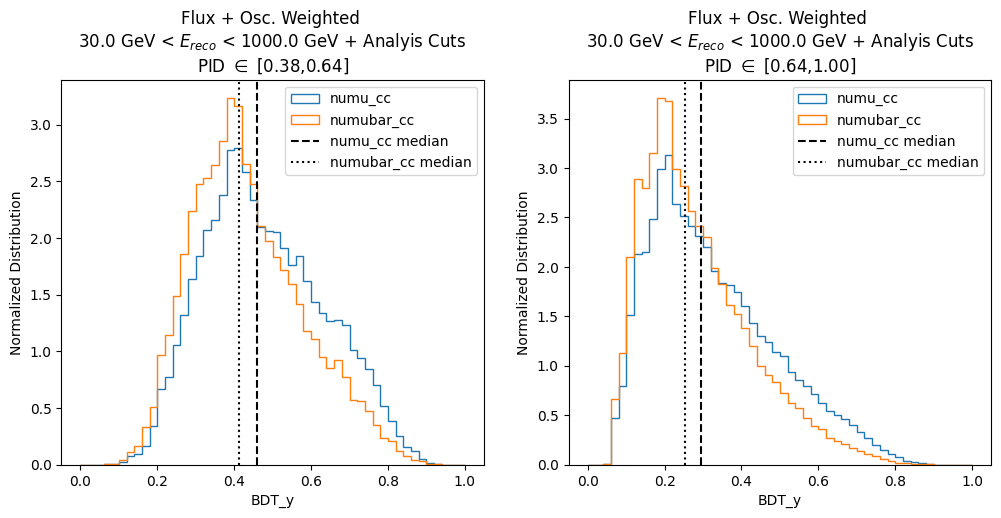

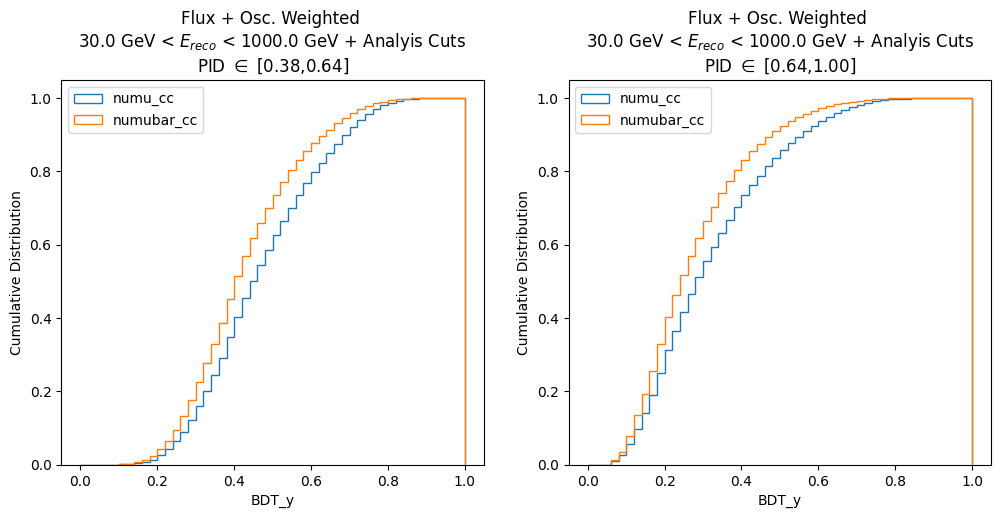

In [118]:
min_E_reco = 30
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[0].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[0].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Normalized Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[1].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[1].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Normalized Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()

#cumulative

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Cumulative Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Cumulative Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()


In [119]:
(weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))

(0.45927444258864075, 0.41522110086102837)

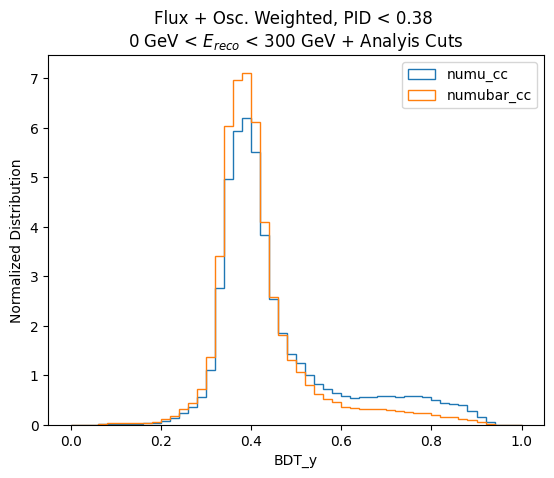

In [120]:
numu_cc_reco_E_cut = (0 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (0 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
plt.xlabel('BDT_y')
plt.ylabel('Normalized Distribution')
plt.title('Flux + Osc. Weighted, PID < %0.2f \n' % (PIDbins[0])+r'0 GeV < $E_{reco}$ < 300 GeV + Analyis Cuts')
plt.legend()

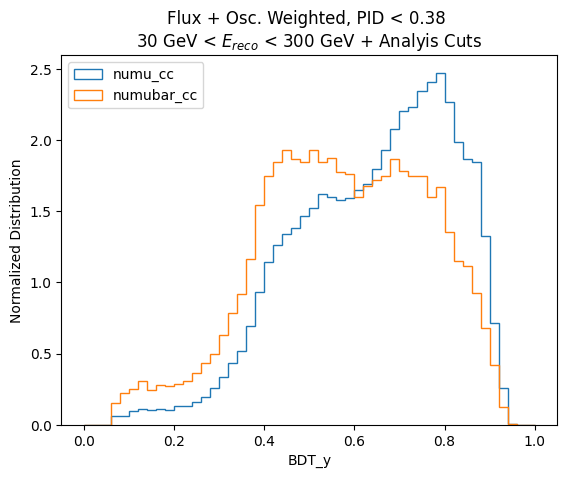

In [121]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
plt.xlabel('BDT_y')
plt.ylabel('Normalized Distribution')
plt.title('Flux + Osc. Weighted, PID < %0.2f \n' % (PIDbins[0])+r'30 GeV < $E_{reco}$ < 300 GeV + Analyis Cuts')
plt.legend()

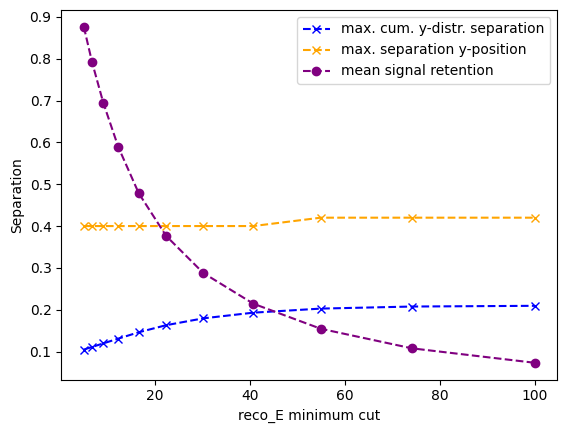

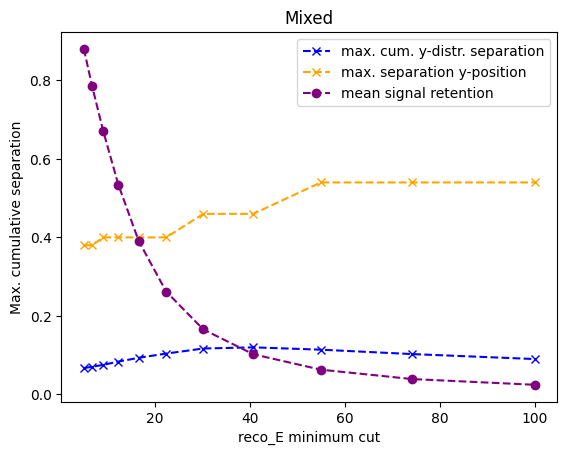

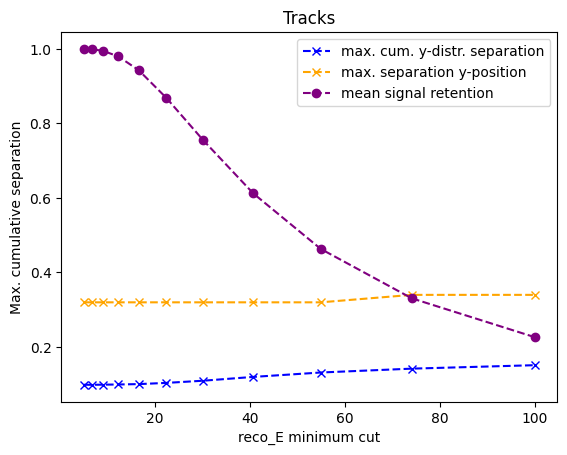

In [122]:
Er_cuts = np.geomspace(5,100,11)
max_E_reco = 1e3
ybins=np.linspace(0,1,51) 
max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [numubar_cc_analysis_cuts] > E)/2)

plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Separation')
plt.show()

max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [mixed_numu_cc & numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts] > E)/2)


plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Max. cumulative separation')
plt.title('Mixed')
plt.show()

max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [high_numu_cc & numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [high_numubar_cc & numubar_cc_analysis_cuts] > E)/2)

plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Max. cumulative separation')
plt.title('Tracks')
plt.show()

## PISA y, PID split

In [123]:
from pisa.core.distribution_maker import DistributionMaker

In [124]:
path = "/afs/ifh.de/user/b/buchholl/scratch/software/fridge/analysis/"
neutrino_pipeline_pid_split = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_basic.cfg"
neutrino_pipeline_y_split = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_basic_ysplit.cfg"

In [125]:
# Create a template distribution maker using the pipeline cfg file.
template_maker_pid = DistributionMaker(neutrino_pipeline_pid_split)

In [126]:
pid_template = template_maker_pid.get_outputs(return_sum=False)

(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': '${\\nu_\\mu} \\, {\\rm CC},{\\;}{\\rm PID}={\\rm cascades}$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
 <matplotlib.colorbar.Colorbar at 0x7f451f815960>)

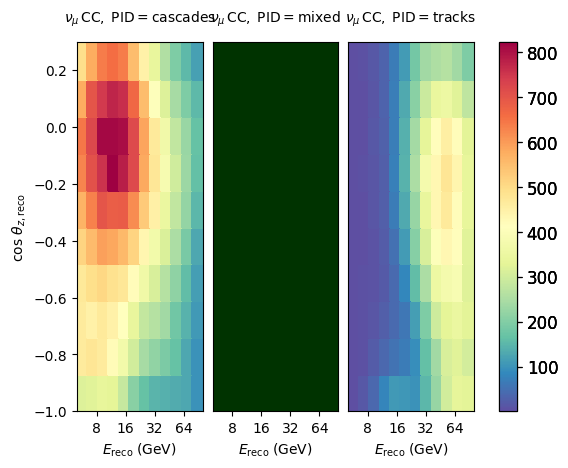

In [127]:
pid_template[0]['numu_cc'].plot()

In [128]:
dir(pid_template[0]['numu_cc'].slice(pid='mixed'))

[ WARNING] /afs/ifh.de/group/amanda/scratch/buchholl/software/pisa/pisa/core/binning.py:3031: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_mask = None if self.mask is None else self.mask[index]



['_Map__rdiv',
 '_Map__rsub',
 '__abs__',
 '__add__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__pretty__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_binning',
 '_full_comparison',
 '_hash',
 '_hist',
 '_name',
 '_normalize_values',
 '_repr_pretty_',
 '_slice_or_index',
 '_slots',
 '_state_attrs',
 '_tex',
 'allclose',
 'assert_compat',
 'barlow_llh',
 'binning',
 'chi2',
 'compare',
 'conv_llh',
 'correct_chi2',
 'downsample',
 'fluctuate',
 'from_json',
 'fu

In [129]:
for flv in pid_template[0]:
    print(dir(flv))

['_Map__rdiv', '_Map__rsub', '__abs__', '__add__', '__class__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__pow__', '__pretty__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_binning', '_full_comparison', '_hash', '_hist', '_name', '_normalize_values', '_repr_pretty_', '_slice_or_index', '_slots', '_state_attrs', '_tex', 'allclose', 'assert_compat', 'barlow_llh', 'binning', 'chi2', 'compare', 'conv_llh', 'correct_chi2', 'downsample', 'fluctuate', 'from_json', 'full_comparison', 'generalized_poisson_llh', 'hash', 'hashable_state', '

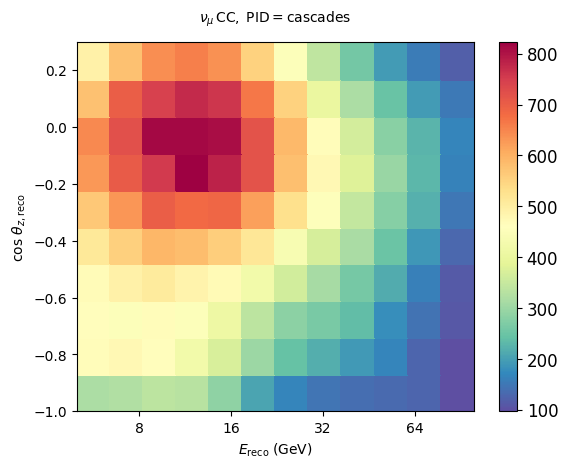

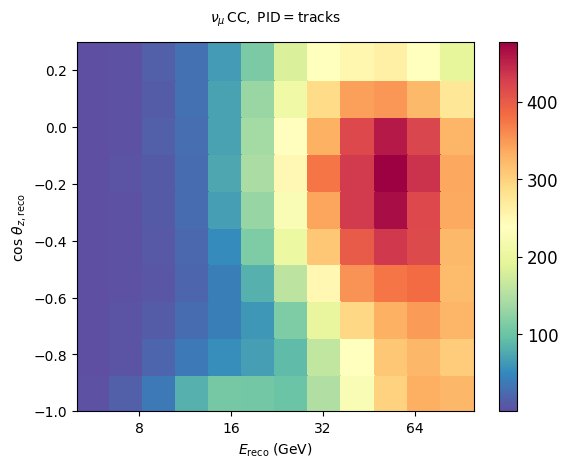

In [130]:
for mapp in pid_template[0]['numu_cc'].split('pid'):
    if 'mixed' in mapp.name:
        continue
    else:
        mapp.plot()

In [131]:
template_maker_y = DistributionMaker(neutrino_pipeline_y_split)

In [132]:
y_template = template_maker_y.get_outputs(return_sum=False)

(<Figure size 640x480 with 4 Axes>,
 <Axes: title={'center': '${\\nu_\\mu} \\, {\\rm CC},{\\;}{\\rm BDT_y}={\\rm low{\\;}y,{\\;}mixed{\\;}PID}$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
 <matplotlib.colorbar.Colorbar at 0x7f4520266410>)

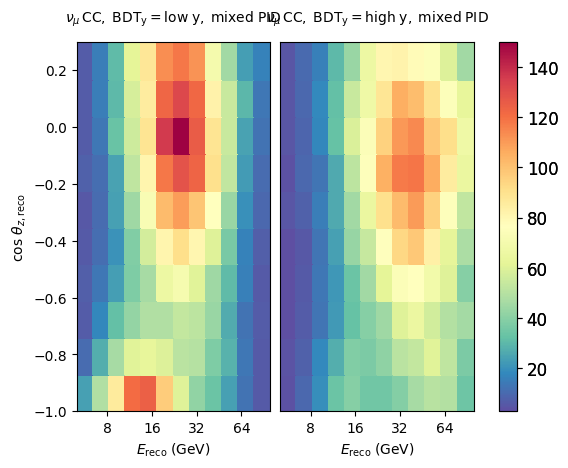

In [133]:
y_template[0]['numu_cc'].plot()

In [134]:
dir(y_template[0]['numu_cc'])

['_Map__rdiv',
 '_Map__rsub',
 '__abs__',
 '__add__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__pretty__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_binning',
 '_full_comparison',
 '_hash',
 '_hist',
 '_name',
 '_normalize_values',
 '_repr_pretty_',
 '_slice_or_index',
 '_slots',
 '_state_attrs',
 '_tex',
 'allclose',
 'assert_compat',
 'barlow_llh',
 'binning',
 'chi2',
 'compare',
 'conv_llh',
 'correct_chi2',
 'downsample',
 'fluctuate',
 'from_json',
 'fu

In [135]:
y_template[0]['numu_cc']

Map(
    name='numu_cc',
    tex='{\\nu_\\mu} \\, {\\rm CC}',
    full_comparison=False,
    hash=None,
    parent_indexer=None,
    binning=MultiDimBinning([
        OneDimBinning('reco_energy', 12 logarithmically-regular bins spanning [5.000000000000001, 100.0] GeV (behavior is logarithmic))),
        OneDimBinning('reco_coszen', 10 linearly-regular bins spanning [-1.0, 0.3] (behavior is linear))),
        OneDimBinning('BDT_y', 2 bins with edges at [0.0, 0.34, 1.0] (behavior is linear), bin_names=['low y, mixed PID', 'high y, mixed PID']))]),
    hist=array([[[23.950833998530257+/-1.3316727996277922,
             4.018653491165053+/-0.5508092605505365],
            [10.880121401388037+/-0.9093972599152907,
             4.237034904173408+/-0.5850520270410371],
            [6.5679376415065835+/-0.6919899818398325,
             3.3705789693007278+/-0.5298296617237939],
            [7.422873592647258+/-0.7951856431544241,
             2.927750682611329+/-0.5201303211832343],
           

In [136]:
pid_signal_both = pid_template[0]['numu_cc']+pid_template[0]['numubar_cc']
pid_signal_numubar = pid_template[0]['numubar_cc']

pid_bkg_both = (pid_template[0]['numu_nc']+pid_template[0]['numubar_nc']+
                pid_template[0]['nue_cc']+pid_template[0]['nuebar_cc']+
                pid_template[0]['nue_nc']+pid_template[0]['nuebar_nc']+
                pid_template[0]['nutau_cc']+pid_template[0]['nutaubar_cc']+
                pid_template[0]['nutau_nc']+pid_template[0]['nutaubar_nc'])

pid_bkg_numubar = (pid_template[0]['numu_cc']+
                   pid_template[0]['numu_nc']+pid_template[0]['numubar_nc']+
                   pid_template[0]['nue_cc']+pid_template[0]['nuebar_cc']+
                   pid_template[0]['nue_nc']+pid_template[0]['nuebar_nc']+
                   pid_template[0]['nutau_cc']+pid_template[0]['nutaubar_cc']+
                   pid_template[0]['nutau_nc']+pid_template[0]['nutaubar_nc'])

y_signal_both = y_template[0]['numu_cc']+y_template[0]['numubar_cc']
y_signal_numubar = y_template[0]['numubar_cc']

y_bkg_both = (y_template[0]['numu_nc']+y_template[0]['numubar_nc']+
                y_template[0]['nue_cc']+y_template[0]['nuebar_cc']+
                y_template[0]['nue_nc']+y_template[0]['nuebar_nc']+
                y_template[0]['nutau_cc']+y_template[0]['nutaubar_cc']+
                y_template[0]['nutau_nc']+y_template[0]['nutaubar_nc'])

y_bkg_numubar = (y_template[0]['numu_cc']+
                 y_template[0]['numu_nc']+y_template[0]['numubar_nc']+
                 y_template[0]['nue_cc']+y_template[0]['nuebar_cc']+
                 y_template[0]['nue_nc']+y_template[0]['nuebar_nc']+
                 y_template[0]['nutau_cc']+y_template[0]['nutaubar_cc']+
                 y_template[0]['nutau_nc']+y_template[0]['nutaubar_nc'])

In [137]:
signi_cascs_both = pid_signal_both.slice(pid='cascades').sum('pid').compare(pid_bkg_both.slice(pid='cascades').sum('pid').sqrt())['fract']
signi_mixed_ylow_both = y_signal_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare(y_bkg_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_mixed_yhigh_both = y_signal_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare(y_bkg_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_tracks_both = pid_signal_both.slice(pid='tracks').sum('pid').compare(pid_bkg_both.slice(pid='tracks').sum('pid').sqrt())['fract']

signi_cascs_numubar = pid_signal_numubar.slice(pid='cascades').sum('pid').compare(pid_bkg_numubar.slice(pid='cascades').sum('pid').sqrt())['fract']
signi_mixed_ylow_numubar = y_signal_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare(y_bkg_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_mixed_yhigh_numubar = y_signal_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare(y_bkg_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_tracks_numubar = pid_signal_numubar.slice(pid='tracks').sum('pid').compare(pid_bkg_numubar.slice(pid='tracks').sum('pid').sqrt())['fract']

[ WARNING] /afs/ifh.de/group/amanda/scratch/buchholl/software/pisa/pisa/core/binning.py:3031: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_mask = None if self.mask is None else self.mask[index]



((<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = cascades, s/\\sqrt{b}, s=\\nu_\\mu-cc,\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f454a0cab90>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = mixed, y = low, s/\\sqrt{b}, s=\\nu_\\mu-cc,\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f45204a0f10>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = mixed, y = high, s/\\sqrt{b}, s=\\nu_\\mu-cc,\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f451ff99030>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = tracks, s/\\sqrt{b}, s=\\nu_\\mu-cc,\\ba

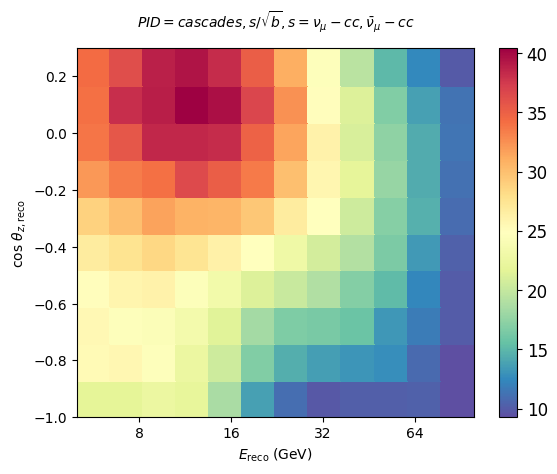

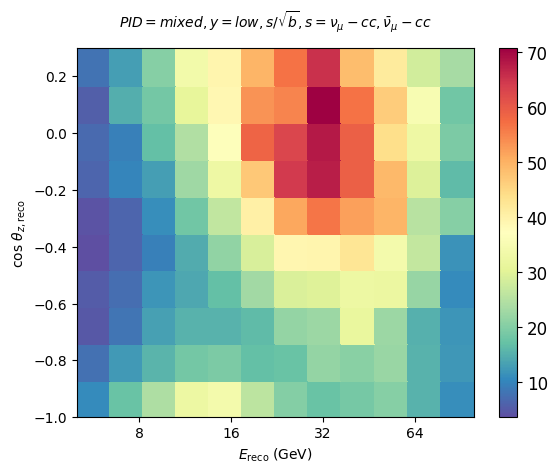

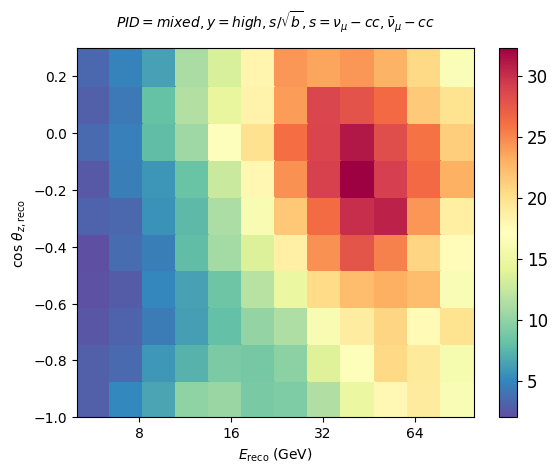

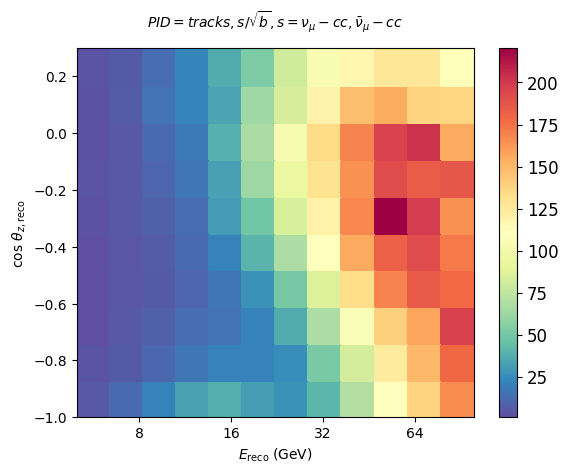

In [138]:
(signi_cascs_both.plot(title=r'$PID = cascades, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_mixed_ylow_both.plot(title=r'$PID = mixed, y = low, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_mixed_yhigh_both.plot(title=r'$PID = mixed, y = high, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_tracks_both.plot(title=r'$PID = tracks, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'))

((<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = cascades, s/\\sqrt{b}, s=\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f4520ffedd0>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = mixed, y = low, s/\\sqrt{b}, s=\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f45210b6470>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = mixed, y = high, s/\\sqrt{b}, s=\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
  <matplotlib.colorbar.Colorbar at 0x7f45200ee3e0>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: title={'center': '$PID = tracks, s/\\sqrt{b}, s=\\bar{\\nu}_\\mu-cc$'}, xlabel='$E_{\\rm reco} \\; \\lef

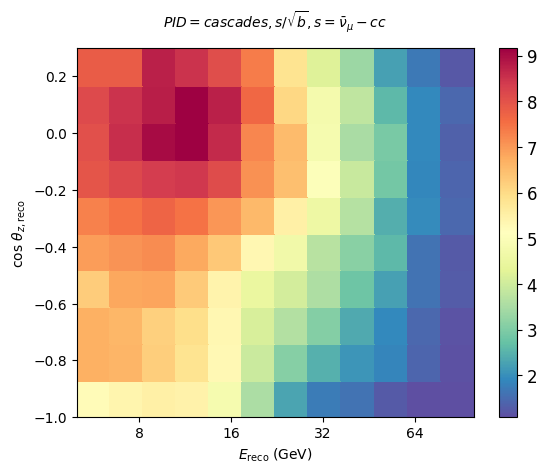

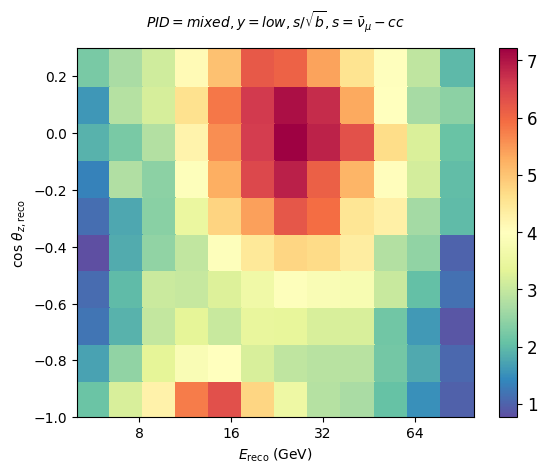

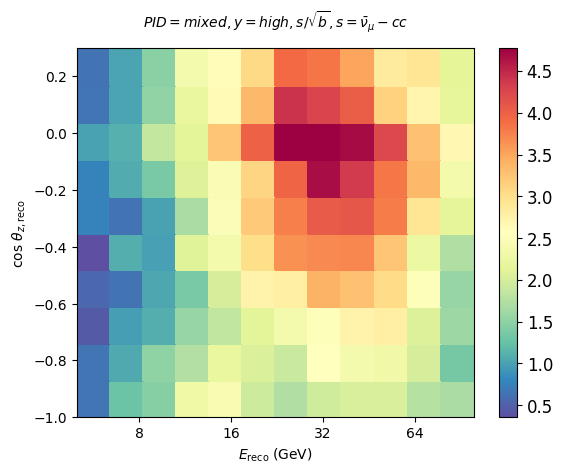

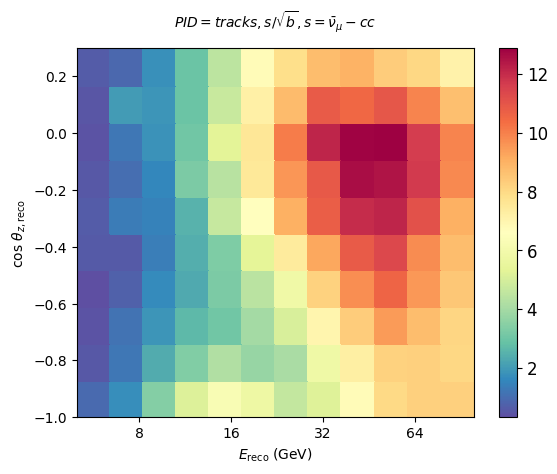

In [139]:
(signi_cascs_numubar.plot(title=r'$PID = cascades, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_mixed_ylow_numubar.plot(title=r'$PID = mixed, y = low, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_mixed_yhigh_numubar.plot(title=r'$PID = mixed, y = high, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_tracks_numubar.plot(title=r'$PID = tracks, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'))

In [140]:
pid_casc_purity = pid_signal_both.slice(pid='cascades').sum('pid').compare((pid_bkg_both+pid_signal_both).slice(pid='cascades').sum('pid'))['fract']
ysplit_low_purity = y_signal_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare((y_bkg_both+y_signal_both).slice(BDT_y='low y, mixed PID').sum('BDT_y'))['fract']
ysplit_high_purity = y_signal_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare((y_bkg_both+y_signal_both).slice(BDT_y='high y, mixed PID').sum('BDT_y'))['fract']
pid_mixed_purity = y_signal_both.sum('BDT_y').compare((y_bkg_both+y_signal_both).sum('BDT_y'))['fract']
pid_tracks_purity = pid_signal_both.slice(pid='tracks').sum('pid').compare((pid_bkg_both+pid_signal_both).slice(pid='tracks').sum('pid'))['fract']

[ WARNING] /afs/ifh.de/group/amanda/scratch/buchholl/software/pisa/pisa/core/binning.py:3031: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_mask = None if self.mask is None else self.mask[index]



In [141]:
(
pid_signal_both.slice(pid='cascades').sum()/(pid_bkg_both+pid_signal_both).slice(pid='cascades').sum(),
y_signal_both.slice(BDT_y='low y, mixed PID').sum()/(y_bkg_both+y_signal_both).slice(BDT_y='low y, mixed PID').sum(),
y_signal_both.slice(BDT_y='high y, mixed PID').sum()/(y_bkg_both+y_signal_both).slice(BDT_y='high y, mixed PID').sum(),
y_signal_both.sum()/(y_bkg_both+y_signal_both).sum(),
pid_signal_both.slice(pid='tracks').sum()/(pid_bkg_both+pid_signal_both).slice(pid='tracks').sum(),
)

(0.4994567810503119+/-0.0004687259210643835,
 0.888565676610001+/-0.0009648166009274708,
 0.7678878631355702+/-0.001347306680275741,
 0.8275419387086379+/-0.000840404137994706,
 0.9588433680716878+/-0.0003352118577300259)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'FLERCNN, PID=tracks, $\\nu_\\mu,\\bar{\\nu}_\\mu$ purity'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
 <matplotlib.colorbar.Colorbar at 0x7f451f0be8f0>)

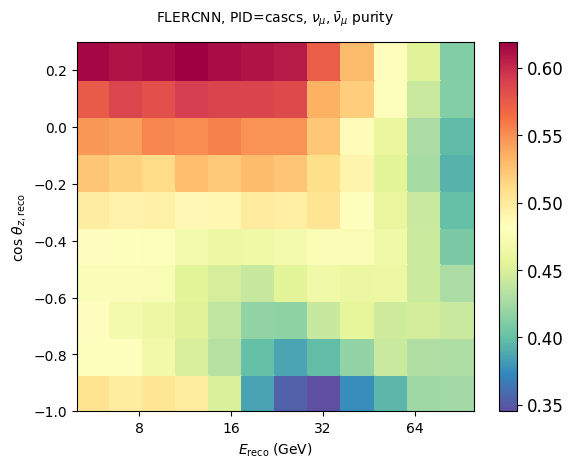

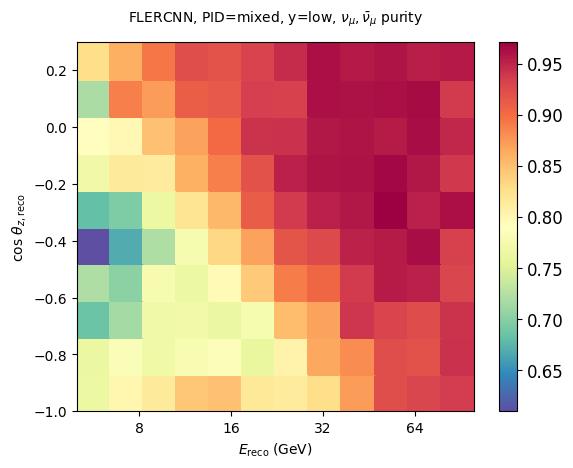

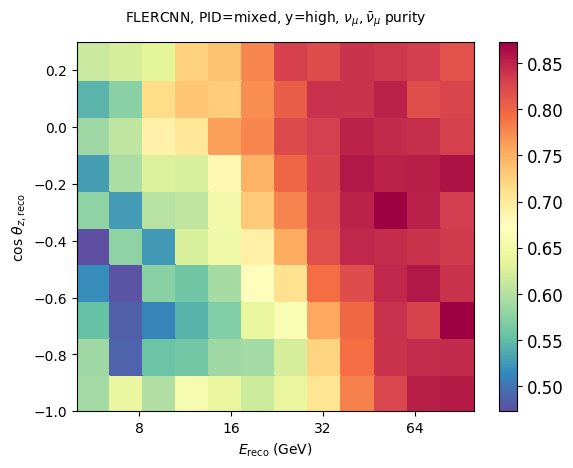

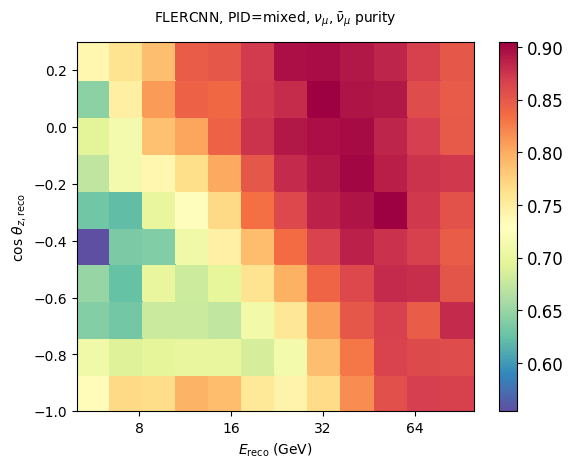

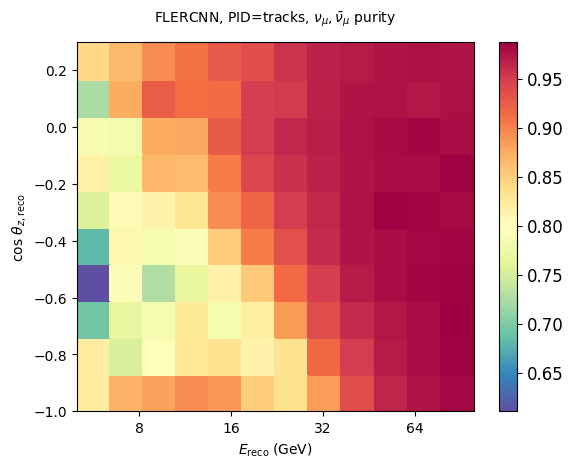

In [142]:
pid_casc_purity.plot(title=r'FLERCNN, PID=cascs, $\nu_\mu,\bar{\nu}_\mu$ purity')
ysplit_low_purity.plot(title=r'FLERCNN, PID=mixed, y=low, $\nu_\mu,\bar{\nu}_\mu$ purity')
ysplit_high_purity.plot(title=r'FLERCNN, PID=mixed, y=high, $\nu_\mu,\bar{\nu}_\mu$ purity')
pid_mixed_purity.plot(title=r'FLERCNN, PID=mixed, $\nu_\mu,\bar{\nu}_\mu$ purity')
pid_tracks_purity.plot(title=r'FLERCNN, PID=tracks, $\nu_\mu,\bar{\nu}_\mu$ purity')

In [143]:
numubar_cc_fract_pid_cascs = pid_signal_numubar.slice(pid='cascades').sum('pid').compare((pid_bkg_numubar+pid_signal_numubar).slice(pid='cascades').sum('pid'))['fract']
numubar_cc_fract_y_low = y_signal_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).slice(BDT_y='low y, mixed PID').sum('BDT_y'))['fract']
numubar_cc_fract_y_high =  y_signal_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).slice(BDT_y='high y, mixed PID').sum('BDT_y'))['fract']
numubar_cc_fract_pid_mixed =  y_signal_numubar.sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).sum('BDT_y'))['fract']
numubar_cc_fract_pid_tracks = pid_signal_numubar.slice(pid='tracks').sum('pid').compare((pid_bkg_numubar+pid_signal_numubar).slice(pid='tracks').sum('pid'))['fract']

[ WARNING] /afs/ifh.de/group/amanda/scratch/buchholl/software/pisa/pisa/core/binning.py:3031: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_mask = None if self.mask is None else self.mask[index]



In [144]:
(
pid_signal_numubar.slice(pid='cascades').sum()/(pid_bkg_numubar+pid_signal_numubar).slice(pid='cascades').sum(),
y_signal_numubar.slice(BDT_y='low y, mixed PID').sum()/(y_bkg_numubar+y_signal_numubar).slice(BDT_y='low y, mixed PID').sum(),
y_signal_numubar.slice(BDT_y='high y, mixed PID').sum()/(y_bkg_numubar+y_signal_numubar).slice(BDT_y='high y, mixed PID').sum(),
y_signal_numubar.sum()/(y_bkg_numubar+y_signal_numubar).sum(),
pid_signal_numubar.slice(pid='tracks').sum()/(pid_bkg_numubar+pid_signal_numubar).slice(pid='tracks').sum(),
)

(0.1440422410017777+/-0.00034271920386296845,
 0.32976106654391574+/-0.0016517473418303777,
 0.2336074677019801+/-0.0014929266165661466,
 0.2811386077416914+/-0.0011184365435286704,
 0.34199847820447027+/-0.0009603909808226435)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '${\\bar\\nu_\\mu} \\, {\\rm CC}$'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
 <matplotlib.colorbar.Colorbar at 0x7f45473ad270>)

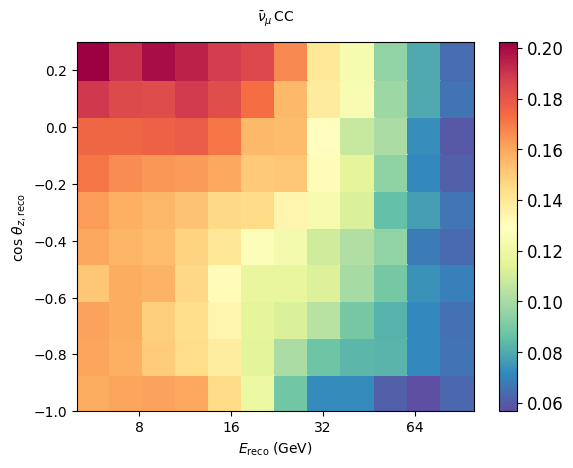

In [145]:
numubar_cc_fract_pid_cascs.plot()

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'FLERCNN, PID=tracks, $\\bar{\\nu}_\\mu$-fraction'}, xlabel='$E_{\\rm reco} \\; \\left( \\mathrm{GeV} \\right)$', ylabel='$\\cos\\,\\theta_{z,{\\rm reco}}$'>,
 <matplotlib.colorbar.Colorbar at 0x7f451ee99a20>)

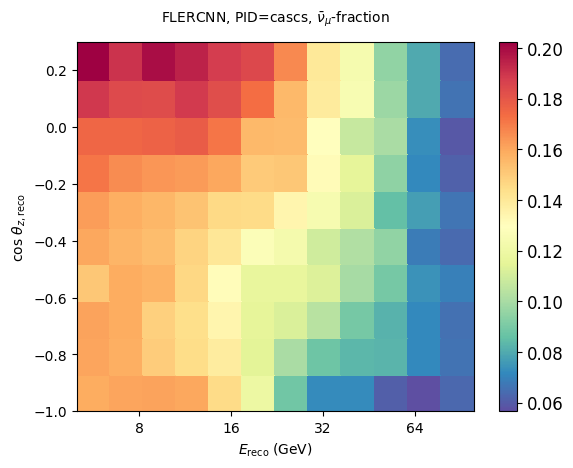

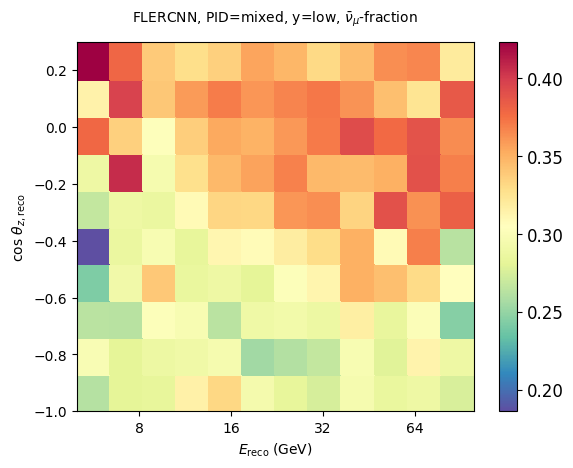

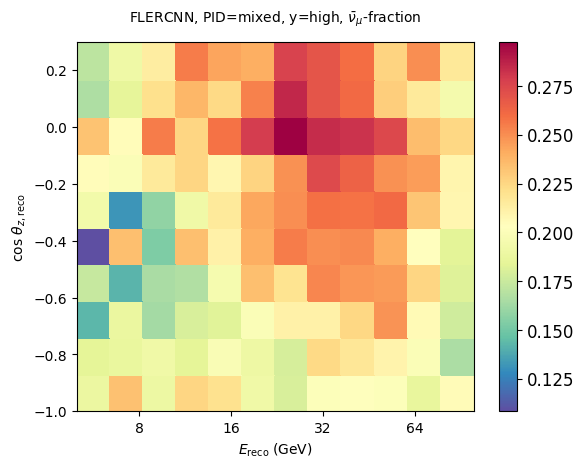

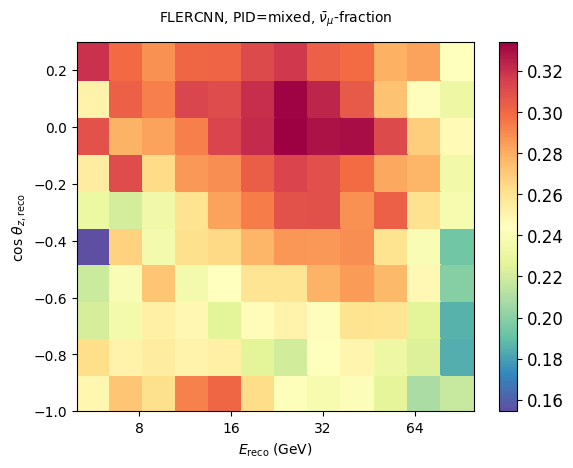

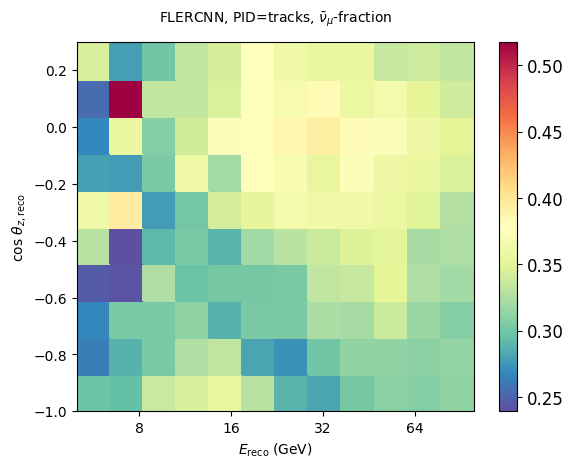

In [146]:
numubar_cc_fract_pid_cascs.plot(title=r'FLERCNN, PID=cascs, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_y_low.plot(title=r'FLERCNN, PID=mixed, y=low, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_y_high.plot(title=r'FLERCNN, PID=mixed, y=high, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_pid_mixed.plot(title=r'FLERCNN, PID=mixed, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_pid_tracks.plot(title=r'FLERCNN, PID=tracks, $\bar{\nu}_\mu$-fraction')

In [147]:
for i in numubar_cc_fract_pid_cascs.plot():
    plt.close()
    print(type(i))

<class 'matplotlib.figure.Figure'>
<class 'matplotlib.axes._axes.Axes'>
<class 'matplotlib.collections.QuadMesh'>
<class 'matplotlib.colorbar.Colorbar'>


In [148]:
fig,axq,quad,cbar=numubar_cc_fract_pid_cascs.plot();
plt.close()

In [149]:
quad.properties().keys()

dict_keys(['agg_filter', 'alpha', 'animated', 'antialiased', 'array', 'capstyle', 'children', 'clim', 'clip_box', 'clip_on', 'clip_path', 'cmap', 'coordinates', 'edgecolor', 'facecolor', 'figure', 'fill', 'gid', 'hatch', 'in_layout', 'joinstyle', 'label', 'linestyle', 'linewidth', 'mouseover', 'offset_transform', 'offsets', 'path_effects', 'paths', 'picker', 'pickradius', 'rasterized', 'sketch_params', 'snap', 'tightbbox', 'transform', 'transformed_clip_path_and_affine', 'transforms', 'url', 'urls', 'visible', 'window_extent', 'zorder'])

In [150]:
axq.properties().keys()

dict_keys(['adjustable', 'agg_filter', 'alpha', 'anchor', 'animated', 'aspect', 'autoscale_on', 'autoscalex_on', 'autoscaley_on', 'axes_locator', 'axisbelow', 'box_aspect', 'children', 'clip_box', 'clip_on', 'clip_path', 'data_ratio', 'default_bbox_extra_artists', 'facecolor', 'figure', 'frame_on', 'gid', 'gridspec', 'images', 'in_layout', 'label', 'legend', 'legend_handles_labels', 'lines', 'mouseover', 'navigate', 'navigate_mode', 'path_effects', 'picker', 'position', 'rasterization_zorder', 'rasterized', 'shared_x_axes', 'shared_y_axes', 'sketch_params', 'snap', 'subplotspec', 'tightbbox', 'title', 'transform', 'transformed_clip_path_and_affine', 'url', 'visible', 'window_extent', 'xaxis', 'xaxis_transform', 'xbound', 'xgridlines', 'xlabel', 'xlim', 'xmajorticklabels', 'xminorticklabels', 'xscale', 'xticklabels', 'xticklines', 'xticks', 'yaxis', 'yaxis_transform', 'ybound', 'ygridlines', 'ylabel', 'ylim', 'ymajorticklabels', 'yminorticklabels', 'yscale', 'yticklabels', 'yticklines',

In [151]:
props = quad.properties()
co = props['coordinates']

In [152]:
xco = list(np.array(co[0][:,0]))
yco = list(np.array(co[:,1][:,1]))

In [153]:
y_co=[]
for i in yco:
    y_co.append([i]*len(xco))
y_co=np.array(y_co)

x_co=[]
for i in yco:
    x_co.append(xco)
x_co=np.array(x_co)

In [209]:
def pisaplot(plotax,axobj,quadobj,title=False,cbar=False,plotyts=True,plotxts=True,vmin=False,vmax=False,tfs=14):
    '''
    PISA plot format to subplot format function. Converts single PISA map into pcolormeshplot on specified axis.
    '''

    qprops = quadobj.properties()
    axprops = axobj.properties()

    co = qprops['coordinates']
    xco = list(np.array(co[0][:,0]))
    yco = list(np.array(co[:,1][:,1]))

    y_co=[]
    for i in yco:
        y_co.append([i]*len(xco))
    y_co=np.array(y_co)
    
    x_co=[]
    for i in yco:
        x_co.append(xco)
    x_co=np.array(x_co)

    clim = qprops['clim']
    cmap = qprops['cmap']
    data = qprops['array']
    xts = axprops['xmajorticklabels']
    yts = axprops['ymajorticklabels']
    
    xts_pos,xts_label=[],[]

    for st in xts:
        xts_pos.append(st.get_position()[0])
        xts_label.append(st.get_text())
        
    yts_pos,yts_label=[],[]
    
    for st in yts:
        yts_pos.append(st.get_position()[1])
        yts_label.append(st.get_text())    

    if not vmin and not vmax:
        cb=plotax.pcolormesh(x_co,y_co,data,cmap=cmap)
    else:
        cb=plotax.pcolormesh(x_co,y_co,data,cmap=cmap,vmin=vmin,vmax=vmax)
        
    if plotxts==True:
        plotax.set_xscale(axprops['xscale'])
        plotax.set_xlabel(axprops['xlabel'])
        plotax.set_xticks(xts_pos,labels=xts_label)
    else:
        plotax.set_xticks(xts_pos,labels=xts_label)

    if plotyts==True:
        plotax.set_yscale(axprops['yscale'])
        plotax.set_ylabel(axprops['ylabel'])      
        plotax.set_yticks(yts_pos,labels=yts_label)  
    else:
        plotax.set_yticks(yts_pos,labels=yts_label) 
    
    plotax.set_xlim(axprops['xlim'])
    plotax.set_ylim(axprops['ylim'])      
    
    if not title:
        plotax.set_title(axprops['title'])
    else:
        plotax.set_title(title,fontsize=tfs)

    if cbar==True:
        fig.colorbar(cb,ax=plotax)

    return cb,clim

In [210]:
_,ax_casc,quad_casc,_=numubar_cc_fract_pid_cascs.plot();
plt.close()
_,ax_ylow,quad_ylow,_=numubar_cc_fract_y_low.plot();
plt.close()
_,ax_yhigh,quad_yhigh,_=numubar_cc_fract_y_high.plot();
plt.close()
_,ax_mixed,quad_mixed,_=numubar_cc_fract_pid_mixed.plot();
plt.close()
_,ax_trk,quad_trk,_=numubar_cc_fract_pid_tracks.plot();
plt.close()

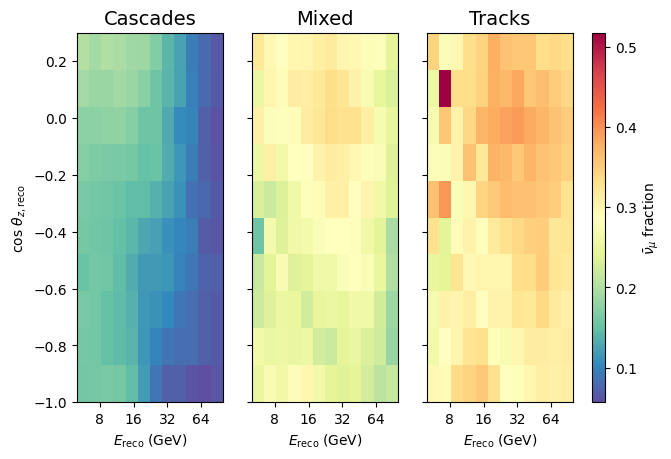

In [211]:
vmin = min([quad_casc.properties()['clim'],quad_mixed.properties()['clim'],quad_trk.properties()['clim']])[0]
vmax = max([quad_casc.properties()['clim'],quad_mixed.properties()['clim'],quad_trk.properties()['clim']])[1]

fig,axes = plt.subplots(1,3,sharey=True)
casc_vs=pisaplot(axes[0],ax_casc,quad_casc,title='Cascades',vmin=vmin,vmax=vmax)
mixed_vs=pisaplot(axes[1],ax_mixed,quad_mixed,title='Mixed',plotyts=False,vmin=vmin,vmax=vmax)
trk_vs=pisaplot(axes[2],ax_trk,quad_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

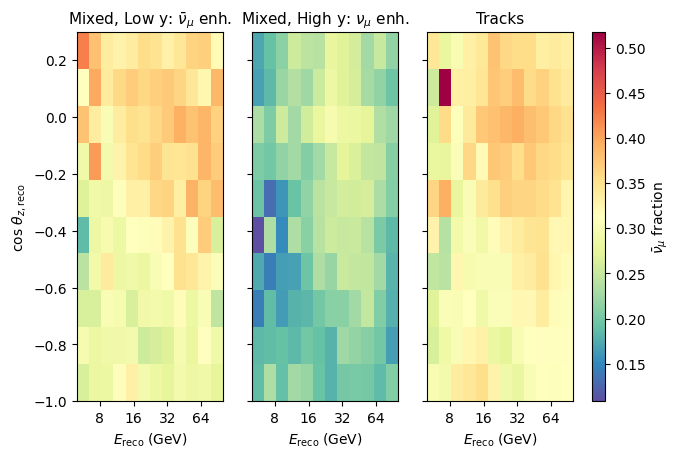

In [216]:
vmin = min([quad_ylow.properties()['clim'],quad_yhigh.properties()['clim'],quad_trk.properties()['clim']])[0]
vmax = max([quad_ylow.properties()['clim'],quad_yhigh.properties()['clim'],quad_trk.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True)
mixedlow_vs=pisaplot(axes[0],ax_ylow,quad_ylow,title=r'Mixed, Low y: $\bar{\nu}_\mu$ enh.',plotyts=True,vmin=vmin,vmax=vmax,tfs=11)
mixedhigh_vs=pisaplot(axes[1],ax_yhigh,quad_yhigh,title=r'Mixed, High y: $\nu_\mu$ enh.',plotyts=False,vmin=vmin,vmax=vmax,tfs=11)
trk_vs=pisaplot(axes[2],ax_trk,quad_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax,tfs=11)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

np.random.seed(1968080810)
# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)

axsLeft = subfigs[0].subplots(1, 2, sharey=True)
subfigs[0].set_facecolor('0.75')
for ax in axsLeft:
    pc = example_plot(ax)
subfigs[0].suptitle('Left plots', fontsize='x-large')
subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

axsRight = subfigs[1].subplots(3, 1, sharex=True)
for nn, ax in enumerate(axsRight):
    pc = example_plot(ax, hide_labels=True)
    if nn == 2:
        ax.set_xlabel('xlabel')
    if nn == 1:
        ax.set_ylabel('ylabel')

subfigs[1].set_facecolor('0.85')
subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
subfigs[1].suptitle('Right plots', fontsize='x-large')

fig.suptitle('Figure suptitle', fontsize='xx-large')

plt.show()

/lustre/fs23/group/icecube/trettin/oscNext/pisa_hdf5/oscnext_santaleera_genie_0000.hdf5






14:15 Uhr
/lustre/fs23/group/icecube/trettin/oscNext/pisa_hdf5/oscnext_santaleera_muongun_130000.hdf5

In [ ]:
pth = '/lustre/fs23/group/icecube/trettin/oscNext/'
sample = pth+'pisa_highstats_hdf5/oscNext_pisa_genie_0000_v02.02.hdf5'
vs_sample = pth+'pisa_hdf5/oscnext_santaleera_genie_0000.hdf5'

In [ ]:
hf_sample = hdf.File(sample,'r')
hf_vs_sample = hdf.File(vs_sample,'r')

In [ ]:
numu_cc_hf_sample = hf_sample['numu_cc']
numu_cc_hf_vs_sample = hf_vs_sample['numu_cc']

In [ ]:
len(numu_cc_hf_sample['weighted_aeff'][:]),len(numu_cc_hf_vs_sample['weighted_aeff'][:])

In [ ]:
np.sum(numu_cc_hf_sample['weighted_aeff'][:]),np.sum(numu_cc_hf_vs_sample['weighted_aeff'][:])

In [ ]:
len(neu_0000['numu_cc']['weighted_aeff'][:]),np.sum(neu_0000['numu_cc']['weighted_aeff'][:])

In [ ]:
nsq_test_pipe = "oscNext_flercnn_sterile/settings/pipeline/neutrinos_pseudodata_mixing_angles_vs_alex.cfg"

template_maker_nsq = DistributionMaker(nsq_test_pipe)

In [ ]:
nsq_vs_template = template_maker_nsq.get_outputs(return_sum=False)[0]

In [ ]:
#VS 
nsq_vs_template['numu_cc'].plot()

In [ ]:
pipepath = 'oscNext_flercnn_sterile/settings/pipeline/'

mixed_lowE_pipe = path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_noysplit_mixed.cfg'
mixed_highE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_ysplit_mixed.cfg'
tracks_lowE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_noysplit_tracks.cfg'
tracks_highE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_ysplit_tracks.cfg'

In [ ]:
mixed_low_E_template_maker = DistributionMaker(mixed_lowE_pipe)
mixed_high_E_template_maker = DistributionMaker(mixed_highE_pipe)
tracks_low_E_template_maker = DistributionMaker(tracks_lowE_pipe)
tracks_high_E_template_maker = DistributionMaker(tracks_highE_pipe)

In [ ]:
mixed_high_E_template = mixed_high_E_template_maker.get_outputs(return_sum=False)[0]

In [ ]:
mixed_high_E_template['numu_cc'].plot()